In [1]:
%load_ext autotime

In [2]:
import pandas as pd
import numpy as np
import glob, shutil
import timeit, os, gc
import subprocess as sp
from tqdm import tqdm
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import json
from IPython.display import HTML
from base64 import b64encode
import cv2


time: 872 ms


In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 4000)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.0)

time: 765 ms


In [4]:
num = 36
HOME = "./"
FFMPEG = "C:/Ffmpeg/bin"
FFMPEG_PATH = FFMPEG
DATA_FOLDER = "C:/Users/jamesjun/Desktop/Simone/DF"
#D:\CueLearning\DFData\Df4Extracted
TMP_FOLDER =  "D:/CueLearning/DFData/DfExtracted"
DATA_FOLDER_TRAIN = DATA_FOLDER
VIDEOS_FOLDER_TRAIN = DATA_FOLDER_TRAIN + "/dfdc_train_part_"+str(num)
IMAGES_FOLDER_TRAIN = TMP_FOLDER + "/images"+str(num)
AUDIOS_FOLDER_TRAIN = TMP_FOLDER + "/audios"+str(num)
CROPPED_IMAGES_FOLDER = TMP_FOLDER + "/cropped_images"+str(num)
EXTRACT_META = True # False
EXTRACT_CONTENT = True # False
EXTRACT_FACES = True # False
FRAME_RATE = 3.0 # Frame per second to extract (max is 30.0)

time: 2 ms


In [5]:
def run_command(*popenargs, **kwargs):
    closeNULL = 0
    try:
        from subprocess import DEVNULL
        closeNULL = 0
    except ImportError:
        import os
        DEVNULL = open(os.devnull, 'wb')
        closeNULL = 1

    process = sp.Popen(stdout=sp.PIPE, stderr=DEVNULL, *popenargs, **kwargs)
    output, unused_err = process.communicate()
    retcode = process.poll()

    if closeNULL:
        DEVNULL.close()

    if retcode:
        cmd = kwargs.get("args")
        if cmd is None:
            cmd = popenargs[0]
        error = sp.CalledProcessError(retcode, cmd)
        error.output = output
        raise error
        
    return output

def ffprobe(filename, options = ["-show_error", "-show_format", "-show_streams", "-show_programs", "-show_chapters", "-show_private_data"]):
    ret = {}
    command = [FFMPEG_PATH + "/ffprobe", "-v", "error", *options, "-print_format", "json", filename]
    ret = run_command(command)
    if ret:
        ret = json.loads(ret)
    return ret

# ffmpeg -i input.mov -r 0.25 output_%04d.png
def ffextract_frames(filename, output_folder, rate = 0.25):
    command = [FFMPEG_PATH + "/ffmpeg", "-i", filename, "-r", str(rate), "-y", output_folder + "/output_%04d.png"]
    ret = run_command(command)
    return ret

# ffmpeg -i input-video.mp4 output-audio.mp3
def ffextract_audio(filename, output_path):
    command = [FFMPEG_PATH + "/ffmpeg", "-i", filename, "-vn", "-ac", "1", "-acodec", "copy", "-y", output_path]
    ret = run_command(command)
    return ret

time: 28 ms


In [6]:
# Extract some meta-data
if EXTRACT_META == True:
    results = []
    subfolder = VIDEOS_FOLDER_TRAIN
    filepaths = glob.glob(subfolder + "/*.mp4")
    for filepath in tqdm(filepaths):
        js = ffprobe(filepath)
        if js:
            if len(js.get("streams", [{}, {}]))>1 : 
                results.append(
                    (js.get("format", {}).get("filename")[len(subfolder) + 1:],
                    js.get("format", {}).get("format_long_name"),
                    # Video 
                    js.get("streams", [{}, {}])[0].get("codec_name"),
                    js.get("streams", [{}, {}])[0].get("height"),
                    js.get("streams", [{}, {}])[0].get("width"),
                    js.get("streams", [{}, {}])[0].get("nb_frames"),
                    js.get("streams", [{}, {}])[0].get("bit_rate"),
                    js.get("streams", [{}, {}])[0].get("duration"),
                    js.get("streams", [{}, {}])[0].get("start_time"),
                    js.get("streams", [{}, {}])[0].get("avg_frame_rate"),
                    # Audio
                    js.get("streams", [{}, {}])[1].get("codec_name"),
                    js.get("streams", [{}, {}])[1].get("channels"),
                    js.get("streams", [{}, {}])[1].get("sample_rate"),
                    js.get("streams", [{}, {}])[1].get("nb_frames"),
                    js.get("streams", [{}, {}])[1].get("bit_rate"),
                    js.get("streams", [{}, {}])[1].get("duration"),
                    js.get("streams", [{}, {}])[1].get("start_time")),
                )
            else :
                results.append(
                    (js.get("format", {}).get("filename")[len(subfolder) + 1:],
                    js.get("format", {}).get("format_long_name"),
                    # Video 
                    js.get("streams", [{}, {}])[0].get("codec_name"),
                    js.get("streams", [{}, {}])[0].get("height"),
                    js.get("streams", [{}, {}])[0].get("width"),
                    js.get("streams", [{}, {}])[0].get("nb_frames"),
                    js.get("streams", [{}, {}])[0].get("bit_rate"),
                    js.get("streams", [{}, {}])[0].get("duration"),
                    js.get("streams", [{}, {}])[0].get("start_time"),
                    js.get("streams", [{}, {}])[0].get("avg_frame_rate"),
                    # Audio
                    np.nan,
                    np.nan,
                    np.nan,
                    np.nan,
                    np.nan,
                    np.nan,
                    np.nan),
                )

    meta_pd = pd.DataFrame(results, columns=["filename", "format", "video_codec_name", "video_height", "video_width",
                                            "video_nb_frames", "video_bit_rate", "video_duration", "video_start_time","video_fps",
                                            "audio_codec_name", "audio_channels", "audio_sample_rate", "audio_nb_frames",
                                            "audio_bit_rate", "audio_duration", "audio_start_time"])
    meta_pd["video_fps"] = meta_pd["video_fps"].apply(lambda x: float(x.split("/")[0])/float(x.split("/")[1]) if len(x.split("/")) == 2 else None)
    meta_pd["video_duration"] = meta_pd["video_duration"].astype(np.float32)
    meta_pd["video_bit_rate"] = meta_pd["video_bit_rate"].astype(np.float32)
    meta_pd["video_start_time"] = meta_pd["video_start_time"].astype(np.float32)
    meta_pd["video_nb_frames"] = meta_pd["video_nb_frames"].astype(np.float32)
    meta_pd["video_bit_rate"] = meta_pd["video_bit_rate"].astype(np.float32)
    meta_pd["audio_sample_rate"] = meta_pd["audio_sample_rate"].astype(np.float32)
    meta_pd["audio_nb_frames"] = meta_pd["audio_nb_frames"].astype(np.float32)
    meta_pd["audio_bit_rate"] = meta_pd["audio_bit_rate"].astype(np.float32)
    meta_pd["audio_duration"] = meta_pd["audio_duration"].astype(np.float32)
    meta_pd["audio_start_time"] = meta_pd["audio_start_time"].astype(np.float32)
    meta_pd.to_pickle(HOME + "videos_meta.pkl")
else:
    meta_pd = pd.read_pickle(HOME + "videos_meta.pkl")
meta_pd.head()

100%|██████████████████████████████████████| 2339/2339 [02:29<00:00, 15.69it/s]


filename           format video_codec_name  video_height  \
0  aadvqhdtxl.mp4  QuickTime / MOV  h264             1080           
1  aaiqsitvnd.mp4  QuickTime / MOV  h264             1080           
2  aakjdfqwnu.mp4  QuickTime / MOV  h264             1080           
3  aalhdlexwx.mp4  QuickTime / MOV  h264             1920           
4  aaonlmxhne.mp4  QuickTime / MOV  h264             1080           

   video_width  video_nb_frames  video_bit_rate  video_duration  \
0  1920         300.0            2556162.0       10.010010        
1  1920         300.0            3067058.0       10.010010        
2  1920         300.0            2721740.0       10.010010        
3  1080         300.0            3192982.0       10.010478        
4  1920         300.0            3009417.0       10.010010        

   video_start_time  video_fps audio_codec_name  audio_channels  \
0  0.0               29.9700    aac              1                
1  0.0               29.9700    aac              1                
2  0.0               29.9700    aac              1                
3  0.0               29.9686    aac              1                
4  0.0               29.9700    aac              1                

   audio_sample_rate  audio_nb_frames  audio_bit_rate  audio_duration  \
0  48000.0            470.0            69301.0         10.0             
1  48000.0            470.0            69350.0         10.0             
2  48000.0            470.0            69289.0         10.0             
3  44100.0            432.0            69251.0         10.0             
4  48000.0            470.0            69267.0         10.0             

   audio_start_time  
0  0.0               
1  0.0               
2  0.0               
3  0.0               
4  0.0

time: 2min 29s


In [7]:
train_pd = pd.read_json(VIDEOS_FOLDER_TRAIN + "/metadata.json").T.reset_index().rename(columns={"index": "filename"})
train_pd.head()

filename label  split        original
0  dcoyfnrpsm.mp4  FAKE  train  dzpychqarm.mp4
1  uqawzjjpre.mp4  FAKE  train  yxsettcask.mp4
2  dcjymntuui.mp4  FAKE  train  xalmvegccm.mp4
3  kglorexrch.mp4  FAKE  train  jshdgdhbek.mp4
4  baktdytfjl.mp4  FAKE  train  rwoelhvtma.mp4

time: 1.12 s


In [8]:
train_pd = pd.merge(train_pd, meta_pd[["filename", "video_height", "video_width", "video_nb_frames", "video_bit_rate", "audio_nb_frames"]], on="filename", how="left")
train_pd["count"] = train_pd.groupby(["original"])["original"].transform('count')
# train_pd.to_pickle(HOME + "train_meta.pkl")
train_pd.head()

filename label  split        original  video_height  video_width  \
0  dcoyfnrpsm.mp4  FAKE  train  dzpychqarm.mp4  1080          1920          
1  uqawzjjpre.mp4  FAKE  train  yxsettcask.mp4  1080          1920          
2  dcjymntuui.mp4  FAKE  train  xalmvegccm.mp4  1080          1920          
3  kglorexrch.mp4  FAKE  train  jshdgdhbek.mp4  1080          1920          
4  baktdytfjl.mp4  FAKE  train  rwoelhvtma.mp4  1080          1920          

   video_nb_frames  video_bit_rate  audio_nb_frames  count  
0  300.0            2593225.0       470.0            8.0    
1  300.0            3037595.0       470.0            10.0   
2  300.0            4051112.0       470.0            11.0   
3  300.0            2845067.0       470.0            10.0   
4  300.0            4092624.0       470.0            10.0

time: 27 ms


In [42]:
train_pd[train_pd["label"] == "REAL"].shape[0]

filename label  split original  video_height  video_width  \
5     pgutuxhmdu.mp4  REAL  train  NaN      1080          1920          
31    ipujpicjxw.mp4  REAL  train  NaN      1080          1920          
38    pogqgrvodn.mp4  REAL  train  NaN      1080          1920          
47    fncypiszkf.mp4  REAL  train  NaN      1080          1920          
48    kdnvfpobng.mp4  REAL  train  NaN      1080          1920          
53    zcswqkeiaq.mp4  REAL  train  NaN      1080          1920          
59    cxzdbwctfx.mp4  REAL  train  NaN      1080          1920          
60    ofullbozco.mp4  REAL  train  NaN      1080          1920          
65    rzxslqqecc.mp4  REAL  train  NaN      1080          1920          
76    xbbmlygnof.mp4  REAL  train  NaN      1080          1920          
84    ioawppxuxf.mp4  REAL  train  NaN      1080          1920          
85    ucputfupah.mp4  REAL  train  NaN      1080          1920          
102   finajvgncq.mp4  REAL  train  NaN      1080          1920          
124   khaeuyycza.mp4  REAL  train  NaN      1080          1920          
127   nmlovqouaz.mp4  REAL  train  NaN      1080          1920          
160   fkyhglxxlk.mp4  REAL  train  NaN      1080          1920          
175   uvhxgaoieh.mp4  REAL  train  NaN      1080          1920          
187   rwoelhvtma.mp4  REAL  train  NaN      1080          1920          
202   ghocibrroi.mp4  REAL  train  NaN      1080          1920          
216   trcmcqzilk.mp4  REAL  train  NaN      1080          1920          
230   idswtwyaat.mp4  REAL  train  NaN      1080          1920          
235   dzpychqarm.mp4  REAL  train  NaN      1080          1920          
269   xfihhsgkqx.mp4  REAL  train  NaN      1080          1920          
272   gtbulzataa.mp4  REAL  train  NaN      1080          1920          
274   xalmvegccm.mp4  REAL  train  NaN      1080          1920          
278   nhdwrthria.mp4  REAL  train  NaN      1080          1920          
285   nemehpslrc.mp4  REAL  train  NaN      1080          1920          
301   uqkbctetpi.mp4  REAL  train  NaN      1080          1920          
303   rkqzmjzzsg.mp4  REAL  train  NaN      1080          1920          
315   jodmpxamjm.mp4  REAL  train  NaN      1080          1920          
334   lpoyrzlnnd.mp4  REAL  train  NaN      1080          1920          
336   turhmezheg.mp4  REAL  train  NaN      1080          1920          
338   ljeqmqyttf.mp4  REAL  train  NaN      1080          1920          
349   ejihiqyvtf.mp4  REAL  train  NaN      1080          1920          
356   ndvgjdyvvg.mp4  REAL  train  NaN      1080          1920          
375   tgobqutmvi.mp4  REAL  train  NaN      1080          1920          
379   luvxqrqcze.mp4  REAL  train  NaN      1080          1920          
383   zevzoxnqlb.mp4  REAL  train  NaN      1080          1920          
388   dpfdxyzenz.mp4  REAL  train  NaN      1080          1920          
404   syeabhanwc.mp4  REAL  train  NaN      1080          1920          
442   lraonebekp.mp4  REAL  train  NaN      1080          1920          
444   linnmxvibu.mp4  REAL  train  NaN      1080          1920          
482   frehtgxiln.mp4  REAL  train  NaN      1080          1920          
489   qyfkgwbubi.mp4  REAL  train  NaN      1080          1920          
491   nqibmvlhsu.mp4  REAL  train  NaN      1080          1920          
498   zegionsphz.mp4  REAL  train  NaN      1080          1920          
502   qpjuficohz.mp4  REAL  train  NaN      1080          1920          
507   jivwoiqeyj.mp4  REAL  train  NaN      1080          1920          
510   pbduywizte.mp4  REAL  train  NaN      1080          1920          
527   dagcolpmki.mp4  REAL  train  NaN      1080          1920          
544   apfdcxttpz.mp4  REAL  train  NaN      1080          1920          
551   townkrjaub.mp4  REAL  train  NaN      1080          1920          
557   djbimbpwbg.mp4  REAL  train  NaN      1080          1920          
563   yeqqlbhgze.mp4  REAL  train  NaN      1080          1920        

time: 190 ms


In [9]:
videos_folder = VIDEOS_FOLDER_TRAIN
images_folder_path = IMAGES_FOLDER_TRAIN
audios_folder_path = AUDIOS_FOLDER_TRAIN

time: 61 ms


In [10]:
"""AUDIO_FORMAT = "wav" # "wav"
videos_folder = VIDEOS_FOLDER_TRAIN
images_folder_path = IMAGES_FOLDER_TRAIN
audios_folder_path = AUDIOS_FOLDER_TRAIN
if EXTRACT_CONTENT == True:
    # 1h20min for chunk#0 (11GB)
    # Extract some images + audio track
    for idx, row in tqdm(train_pd.iterrows(), total=meta_pd.shape[0]):
        try:
            video_path = videos_folder + "/" + row["filename"]
            images_path = images_folder_path + "/" + row["filename"][:-4]
            audio_path = audios_folder_path + "/" + row["filename"][:-4]
            # Extract images
            if not os.path.exists(images_path): os.makedirs(images_path)
            ret = ffextract_frames(video_path, images_path, rate = FRAME_RATE)
            # Extract audio
            #if not os.path.exists(audio_path): os.makedirs(audio_path)
            #ret = ffextract_audio(video_path, audio_path + "/audio." + AUDIO_FORMAT)
        except:
            print("Cannot extract frames/audio for:" + row["filename"])
            """;

time: 19 ms


In [12]:
# RetinaFace face detector
import insightface

model = insightface.model_zoo.get_model('retinaface_r50_v1')
model.prepare(ctx_id = 0, nms=0.4) 

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True
time: 26.2 s


In [13]:
def detect_face_retina(img):
    face_locations = []
    bbox, landmark = model.detect(img, threshold=0.5, scale=1.0)
    for (x,y,x1,y1, conf) in bbox:
        face_location = (int(x), int(y), int(x1), int(y1))
        face_confidence = float(conf)
        face_locations.append((face_location, face_confidence))
        
    return face_locations


time: 2 ms


In [14]:
# return ((x,y,w,h, confidence))
def extract_faces(files, source, detector=detect_face_retina):
    results = []
    # for idx, file in tqdm(enumerate(files), total=len(files)):
    for idx, file in enumerate(files):
        try:
            img = cv2.cvtColor(cv2.imread(file, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
            face_locations = detector(img)
            results.append((source, file[file.find("output_"):], face_locations, len(face_locations)))
        except:
            print("Cannot extract faces for image: %s" % file)
    return results

time: 7 ms


In [15]:
# Plot faces extracted images
def plot_faces_boxes(df, max_cols = 2, max_rows = 6, fsize=(24, 5), max_items=12):    
    idx = 0    
    for item_idx, item in df.iterrows():
        img = cv2.cvtColor(cv2.imread(IMAGES_FOLDER_TRAIN + "/" + item["filename"][:-4] +"/" + item["image"], cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)    
        face_img = img #.copy()
        # grid subplots
        row = idx // max_cols
        col = idx % max_cols
        if col == 0: fig = plt.figure(figsize=fsize)
        ax = fig.add_subplot(1, max_cols, col + 1)
        ax.axis("off")
        # display image with boxes
        cols = [c for c in df.columns if "boxes" in c]
        for i, c in enumerate(cols, 0):
            face_locations = item[c]
            face_confidence = item[c]            
            if len(face_locations) > 0:
                for face_location in face_locations:        
                    ((x,y,w,h), confidence) = face_location
                    # face_img = face_img[y:y+h, x:x+w]
                    cv2.rectangle(face_img, (x, y), (w, h), (255,i*255,0), 8)
                    cv2.putText(face_img, '%.1f' % (confidence*100.0), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (255,i*255,0), 9, cv2.LINE_AA)
                ax.imshow(face_img)
            else:
                ax.imshow(img)
            ax.set_title("%s %s / %s - Faces: %d %s %s" % (item["label"] if "label" in df.columns else "", 
                                                           item["filename"], item["image"],
                                                           item["faces_retina"] if "faces_retina" in df.columns else len(face_locations),
                                                           item["faces_retina_median"] if "faces_retina_median" in df.columns else "",
                                                           item["faces"] if "faces" in df.columns else ""))
        if (col == max_cols -1): plt.show()
        idx = idx + 1
        if (max_items > 0 and idx >=max_items): break

time: 14 ms


In [16]:
def run_detector_on_video(videos_filename, verbose=False):
    if verbose == True: 
        print("Starting with batch of %d videos" % len(videos_filename))
    tmp_faces_pd = None
    for file in videos_filename:
        # Find out dump folder with images
        dump_folder = images_folder_path + "/" + file[:-4]
        # List files
        files = glob.glob(dump_folder + "/*")
        DETECTORS = {
            "retina": detect_face_retina
        }
        for key, value in DETECTORS.items():
            tmp_pd = pd.DataFrame(extract_faces(files, file, detector=value), columns=["filename", "image", "boxes_" + key , "faces_" + key])
            if tmp_faces_pd is None:
                tmp_faces_pd = tmp_pd
            else:
                tmp_faces_pd = pd.concat([tmp_faces_pd, tmp_pd], axis=0)
    return tmp_faces_pd

time: 4 ms


In [17]:
#import multiprocessing
#cpus = multiprocessing.cpu_count()
if EXTRACT_FACES == True:
    resultfutures = []
    results = []
    #tasks = np.array_split(train_pd["filename"].unique(), 20)
    # train_pd["filename"].unique()
    tasks = train_pd[train_pd["label"] == "REAL"]["filename"].unique()
    print("Tasks: %d" % len(tasks))
    #with ThreadPoolExecutor(max_workers=cpus) as executor:
    all_faces_pd = run_detector_on_video(tasks)
    #results = [x for x in resultfutures]
    #executor.shutdown()
    # Gather results
    """all_faces_pd = None
    for result in results:
        if all_faces_pd is None:
            all_faces_pd = result
        else:     
            all_faces_pd = pd.concat([all_faces_pd, result], axis=0)
           
    all_faces_pd = all_faces_pd.reset_index(drop=True)
    """ 
    all_faces_pd.to_pickle(HOME + "faces.pkl")
     
else:
    all_faces_pd = pd.read_pickle(HOME + "faces.pkl")
print(all_faces_pd.shape)

Tasks: 364
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qchgluoajg\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qchgluoajg\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qchgluoajg\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qchgluoajg\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qchgluoajg\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qchgluoajg\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qchgluoajg\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qchgluoajg\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qchgluoajg\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/image

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wqqrghknon\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wqqrghknon\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wqqrghknon\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wqqrghknon\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wqqrghknon\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wqqrghknon\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wqqrghknon\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wqqrghknon\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wqqrghknon\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wqqrghk

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/owlkhaplbc\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/owlkhaplbc\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/owlkhaplbc\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/owlkhaplbc\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/owlkhaplbc\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/owlkhaplbc\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/owlkhaplbc\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/owlkhaplbc\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/owlkhaplbc\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/owlkhap

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xogusjcata\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xogusjcata\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xogusjcata\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xogusjcata\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xogusjcata\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xogusjcata\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xogusjcata\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xogusjcata\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xogusjcata\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xogusjc

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qjcsboclei\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qjcsboclei\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qjcsboclei\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qjcsboclei\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qjcsboclei\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qjcsboclei\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qjcsboclei\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qjcsboclei\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qjcsboclei\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qjcsboc

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/osgxvfnusa\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/osgxvfnusa\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/osgxvfnusa\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/osgxvfnusa\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/osgxvfnusa\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/osgxvfnusa\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/osgxvfnusa\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/osgxvfnusa\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/osgxvfnusa\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fjubmqu

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fyygtwpvcc\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fyygtwpvcc\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fyygtwpvcc\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fyygtwpvcc\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fyygtwpvcc\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fyygtwpvcc\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fyygtwpvcc\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fyygtwpvcc\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fyygtwpvcc\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fyygtwp

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/abvpqidzxi\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/abvpqidzxi\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/abvpqidzxi\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/abvpqidzxi\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/abvpqidzxi\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/abvpqidzxi\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/abvpqidzxi\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ckbdjpflsu\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ckbdjpflsu\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ckbdjpf

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qtyvhcjqwd\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qtyvhcjqwd\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qtyvhcjqwd\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qtyvhcjqwd\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qtyvhcjqwd\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qtyvhcjqwd\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qtyvhcjqwd\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qtyvhcjqwd\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qtyvhcjqwd\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qtyvhcj

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tohigipsdo\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tohigipsdo\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tohigipsdo\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tohigipsdo\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tohigipsdo\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iaeoilngdv\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iaeoilngdv\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iaeoilngdv\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iaeoilngdv\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iaeoiln

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gneeoltznu\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gneeoltznu\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gneeoltznu\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gneeoltznu\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gneeoltznu\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gneeoltznu\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gneeoltznu\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gneeoltznu\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gneeoltznu\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gneeolt

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/kpdgybasbo\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ldasdpxtjb\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ldasdpxtjb\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ldasdpxtjb\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ldasdpxtjb\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ldasdpxtjb\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ldasdpxtjb\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ldasdpxtjb\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ldasdpxtjb\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ldasdpx

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mkscgiqmvg\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mkscgiqmvg\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mkscgiqmvg\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mkscgiqmvg\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mkscgiqmvg\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mkscgiqmvg\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mkscgiqmvg\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mkscgiqmvg\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mkscgiqmvg\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mkscgiq

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/adwujlygpp\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/adwujlygpp\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/adwujlygpp\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/adwujlygpp\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/adwujlygpp\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/adwujlygpp\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/adwujlygpp\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/adwujlygpp\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/adwujlygpp\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/adwujly

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cpsmnqhsck\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cpsmnqhsck\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cpsmnqhsck\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cpsmnqhsck\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cpsmnqhsck\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cpsmnqhsck\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cpsmnqhsck\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cpsmnqhsck\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cpsmnqhsck\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cpsmnqh

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hirzwspuzp\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hirzwspuzp\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hirzwspuzp\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hirzwspuzp\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hirzwspuzp\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hirzwspuzp\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hirzwspuzp\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hirzwspuzp\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hirzwspuzp\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hirzwsp

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/digadpqbnq\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/digadpqbnq\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/digadpqbnq\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/digadpqbnq\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/digadpqbnq\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/digadpqbnq\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/digadpqbnq\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/digadpqbnq\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/digadpqbnq\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/digadpq

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qgjtjtybfe\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qgjtjtybfe\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qgjtjtybfe\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qgjtjtybfe\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qgjtjtybfe\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qgjtjtybfe\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qgjtjtybfe\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qgjtjtybfe\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qgjtjtybfe\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qgjtjty

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ebxnhqeaab\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ebxnhqeaab\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ebxnhqeaab\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ebxnhqeaab\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ebxnhqeaab\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ebxnhqeaab\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ebxnhqeaab\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/vxbnaacnvz\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/vxbnaacnvz\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/vxbnaac

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/reyjdnlcej\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/reyjdnlcej\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/reyjdnlcej\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/reyjdnlcej\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/reyjdnlcej\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/reyjdnlcej\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/reyjdnlcej\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/reyjdnlcej\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/reyjdnlcej\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/reyjdnl

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tdkufbnrgy\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tdkufbnrgy\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qlkzcdofbw\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qlkzcdofbw\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qlkzcdofbw\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qlkzcdofbw\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qlkzcdofbw\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qlkzcdofbw\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qlkzcdofbw\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qlkzcdo

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/meaofsannn\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/meaofsannn\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/meaofsannn\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/meaofsannn\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/meaofsannn\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/meaofsannn\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/meaofsannn\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/meaofsannn\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/meaofsannn\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/meaofsa

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/sjagsjethf\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/sjagsjethf\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/sjagsjethf\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/sjagsjethf\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/sjagsjethf\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/sjagsjethf\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/sjagsjethf\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/sjagsjethf\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/sjagsjethf\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/sjagsje

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zqkhqoiobb\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zqkhqoiobb\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zqkhqoiobb\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zqkhqoiobb\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zqkhqoiobb\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zqkhqoiobb\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zqkhqoiobb\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zqkhqoiobb\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zqkhqoiobb\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zqkhqoi

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zhhbzsxfqo\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zhhbzsxfqo\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zhhbzsxfqo\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zhhbzsxfqo\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zhhbzsxfqo\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zhhbzsxfqo\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zhhbzsxfqo\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zhhbzsxfqo\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zhhbzsxfqo\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zhhbzsx

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/seoomartef\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/seoomartef\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/seoomartef\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/seoomartef\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/seoomartef\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/seoomartef\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/seoomartef\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/seoomartef\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/seoomartef\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/seoomar

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/azhbacpvhg\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/azhbacpvhg\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/azhbacpvhg\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/azhbacpvhg\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/azhbacpvhg\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/azhbacpvhg\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/azhbacpvhg\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/azhbacpvhg\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/azhbacpvhg\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/azhbacp

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/auaqihmsmu\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/auaqihmsmu\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/auaqihmsmu\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/auaqihmsmu\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/auaqihmsmu\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/auaqihmsmu\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/auaqihmsmu\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/auaqihmsmu\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/auaqihmsmu\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xpxssnq

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gnquanigrd\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gnquanigrd\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gnquanigrd\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gnquanigrd\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gnquanigrd\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gnquanigrd\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gnquanigrd\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gnquanigrd\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gnquanigrd\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gnquani

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ajplbzrmld\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ajplbzrmld\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ajplbzrmld\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ajplbzrmld\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ajplbzrmld\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ajplbzrmld\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ajplbzrmld\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yaqmpriaxm\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yaqmpriaxm\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yaqmpri

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/uebkyvdovg\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/uebkyvdovg\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/uebkyvdovg\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/uebkyvdovg\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/uebkyvdovg\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/uebkyvdovg\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/uebkyvdovg\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/uebkyvdovg\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/uebkyvdovg\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/uebkyvd

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mqcuvxipxe\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mqcuvxipxe\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mqcuvxipxe\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mqcuvxipxe\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zkzqeaagaa\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zkzqeaagaa\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zkzqeaagaa\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zkzqeaagaa\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zkzqeaagaa\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zkzqeaa

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cfmxhruvov\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cfmxhruvov\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cfmxhruvov\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cfmxhruvov\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cfmxhruvov\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cfmxhruvov\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cfmxhruvov\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cfmxhruvov\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cfmxhruvov\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cfmxhru

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yyuodrxazd\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yyuodrxazd\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yyuodrxazd\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yyuodrxazd\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yyuodrxazd\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yyuodrxazd\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yyuodrxazd\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yyuodrxazd\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yyuodrxazd\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yyuodrx

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/poebmykhvt\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/poebmykhvt\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/poebmykhvt\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/poebmykhvt\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/poebmykhvt\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/poebmykhvt\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/poebmykhvt\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/poebmykhvt\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/poebmykhvt\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/poebmyk

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/orgpcogfgj\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/orgpcogfgj\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/orgpcogfgj\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/orgpcogfgj\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/orgpcogfgj\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/orgpcogfgj\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/orgpcogfgj\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/orgpcogfgj\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/orgpcogfgj\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/orgpcog

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/obkcsjsjco\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/obkcsjsjco\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/obkcsjsjco\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/obkcsjsjco\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/obkcsjsjco\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/obkcsjsjco\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/obkcsjsjco\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/obkcsjsjco\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/obkcsjsjco\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/obkcsjs

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jfgthbfidq\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jfgthbfidq\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jfgthbfidq\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jfgthbfidq\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jfgthbfidq\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jfgthbfidq\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jfgthbfidq\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jfgthbfidq\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jfgthbfidq\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jfgthbf

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tkrksosymh\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tkrksosymh\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tkrksosymh\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tkrksosymh\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tkrksosymh\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tkrksosymh\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tkrksosymh\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tkrksosymh\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tkrksosymh\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tkrksos

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nucezildwg\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nucezildwg\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nucezildwg\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nucezildwg\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nucezildwg\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nucezildwg\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nucezildwg\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nucezildwg\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nucezildwg\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nucezil

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/kwojbcsrxp\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/kwojbcsrxp\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/kwojbcsrxp\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/kwojbcsrxp\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/kwojbcsrxp\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/kwojbcsrxp\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qqcodichfr\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qqcodichfr\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qqcodichfr\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qqcodic

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/taxszvyhbm\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/taxszvyhbm\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/taxszvyhbm\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/taxszvyhbm\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/taxszvyhbm\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/taxszvyhbm\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/taxszvyhbm\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/taxszvyhbm\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/taxszvyhbm\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/taxszvy

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gqlajpyklv\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gqlajpyklv\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gqlajpyklv\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/arqadmwicu\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/arqadmwicu\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/arqadmwicu\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/arqadmwicu\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/arqadmwicu\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/arqadmwicu\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/arqadmw

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/vodvztthek\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/vodvztthek\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/vodvztthek\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/vodvztthek\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/vodvztthek\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/vodvztthek\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/vodvztthek\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/vodvztthek\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/vodvztthek\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/vodvztt

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fdmsyypemb\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fdmsyypemb\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fdmsyypemb\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fdmsyypemb\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fdmsyypemb\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fdmsyypemb\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fdmsyypemb\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fdmsyypemb\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fdmsyypemb\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fdmsyyp

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tcbksssubn\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tcbksssubn\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tcbksssubn\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tcbksssubn\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tcbksssubn\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tcbksssubn\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tcbksssubn\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tcbksssubn\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tcbksssubn\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tcbksss

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qhhuilcdfg\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qhhuilcdfg\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qhhuilcdfg\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qhhuilcdfg\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qhhuilcdfg\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qhhuilcdfg\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qhhuilcdfg\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qhhuilcdfg\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qhhuilcdfg\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qhhuilc

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/bemqbwgxxs\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/bemqbwgxxs\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/bemqbwgxxs\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/bemqbwgxxs\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/bemqbwgxxs\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/bemqbwgxxs\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/bemqbwgxxs\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/bemqbwgxxs\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/bemqbwgxxs\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/bemqbwg

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yxemrtvovf\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yxemrtvovf\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yxemrtvovf\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yxemrtvovf\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yxemrtvovf\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yxemrtvovf\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yxemrtvovf\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yxemrtvovf\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yxemrtvovf\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yxemrtv

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ghevcqpcur\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ghevcqpcur\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ghevcqpcur\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ghevcqpcur\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ghevcqpcur\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ghevcqpcur\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ghevcqpcur\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/loivoqngeh\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/loivoqngeh\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/loivoqn

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/knmfzlhzzf\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/knmfzlhzzf\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/knmfzlhzzf\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/knmfzlhzzf\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/knmfzlhzzf\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/knmfzlhzzf\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/knmfzlhzzf\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/knmfzlhzzf\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/knmfzlhzzf\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/knmfzlh

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/vhcrrcszbc\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/vhcrrcszbc\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/vhcrrcszbc\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/vhcrrcszbc\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/dtlrlpemur\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/dtlrlpemur\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/dtlrlpemur\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/dtlrlpemur\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/dtlrlpemur\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/dtlrlpe

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ushfsgkbit\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ushfsgkbit\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ushfsgkbit\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ushfsgkbit\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ushfsgkbit\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ushfsgkbit\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ushfsgkbit\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ushfsgkbit\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ushfsgkbit\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ushfsgk

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ahzfqirfkx\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ahzfqirfkx\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/etwejymoqt\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/etwejymoqt\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/etwejymoqt\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/etwejymoqt\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/etwejymoqt\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/etwejymoqt\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/etwejymoqt\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/etwejym

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zvxudeeuzh\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zvxudeeuzh\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zvxudeeuzh\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zvxudeeuzh\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zvxudeeuzh\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zvxudeeuzh\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zvxudeeuzh\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zvxudeeuzh\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zvxudeeuzh\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/zvxudee

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nwvzszmcso\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nwvzszmcso\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nwvzszmcso\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nwvzszmcso\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nwvzszmcso\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nwvzszmcso\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nwvzszmcso\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nwvzszmcso\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nwvzszmcso\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nwvzszm

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yennshallj\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yennshallj\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yennshallj\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yennshallj\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yennshallj\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yennshallj\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yennshallj\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yennshallj\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yennshallj\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yennsha

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/lshxvcdeku\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/lshxvcdeku\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/lshxvcdeku\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/lshxvcdeku\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/lshxvcdeku\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/lshxvcdeku\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/lshxvcdeku\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/lshxvcdeku\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/lshxvcdeku\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/lshxvcd

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ggdlojhunz\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ggdlojhunz\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ggdlojhunz\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ggdlojhunz\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ggdlojhunz\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ggdlojhunz\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ggdlojhunz\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ggdlojhunz\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ggdlojhunz\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ggdlojh

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/meaipafdql\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/meaipafdql\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/meaipafdql\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/meaipafdql\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/meaipafdql\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/meaipafdql\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/meaipafdql\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/meaipafdql\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/meaipafdql\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/meaipaf

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wolgusoonv\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wolgusoonv\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wolgusoonv\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wolgusoonv\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wolgusoonv\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wolgusoonv\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wolgusoonv\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wolgusoonv\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hiokkbarew\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hiokkba

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ehetlufgmx\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ehetlufgmx\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ehetlufgmx\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ehetlufgmx\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ehetlufgmx\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ehetlufgmx\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ehetlufgmx\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ehetlufgmx\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ehetlufgmx\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ehetluf

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ekqtlhsclp\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ekqtlhsclp\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ekqtlhsclp\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ekqtlhsclp\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/dvkxchfqbv\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/dvkxchfqbv\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/dvkxchfqbv\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/dvkxchfqbv\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/dvkxchfqbv\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/dvkxchf

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qjwujikrmf\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qjwujikrmf\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qjwujikrmf\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qjwujikrmf\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qjwujikrmf\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qjwujikrmf\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qjwujikrmf\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qjwujikrmf\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qjwujikrmf\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qjwujik

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/javyvwvmhd\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/javyvwvmhd\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/javyvwvmhd\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/javyvwvmhd\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/javyvwvmhd\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/javyvwvmhd\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/javyvwvmhd\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/javyvwvmhd\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/javyvwvmhd\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/javyvwv

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hpgteigvcc\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hpgteigvcc\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hpgteigvcc\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hpgteigvcc\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hpgteigvcc\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hpgteigvcc\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hpgteigvcc\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hpgteigvcc\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hpgteigvcc\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hpgteig

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jxjyufzczt\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jxjyufzczt\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jxjyufzczt\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jxjyufzczt\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jxjyufzczt\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jxjyufzczt\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jxjyufzczt\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jxjyufzczt\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jxjyufzczt\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jxjyufz

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qsxifntntg\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qsxifntntg\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qsxifntntg\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qsxifntntg\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qsxifntntg\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qsxifntntg\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qsxifntntg\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qsxifntntg\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qsxifntntg\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qsxifnt

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ovqdavuowh\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ovqdavuowh\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ovqdavuowh\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ovqdavuowh\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ovqdavuowh\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ovqdavuowh\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ovqdavuowh\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ovqdavuowh\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ovqdavuowh\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ovqdavu

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ciijjqsrto\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ciijjqsrto\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ciijjqsrto\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ciijjqsrto\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ciijjqsrto\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ciijjqsrto\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ciijjqsrto\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ciijjqsrto\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hdtslvvftc\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hdtslvv

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rcfztfrouh\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rcfztfrouh\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rcfztfrouh\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rcfztfrouh\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rcfztfrouh\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rcfztfrouh\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rcfztfrouh\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rcfztfrouh\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rcfztfrouh\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rcfztfr

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ydjvphftks\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ydjvphftks\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ydjvphftks\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ydjvphftks\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ydjvphftks\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hlbyzsyuai\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hlbyzsyuai\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hlbyzsyuai\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hlbyzsyuai\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hlbyzsy

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nbqsomcotk\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nbqsomcotk\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nbqsomcotk\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nbqsomcotk\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nbqsomcotk\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nbqsomcotk\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nbqsomcotk\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nbqsomcotk\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nbqsomcotk\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nbqsomc

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nutyeqzuex\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nutyeqzuex\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/nutyeqzuex\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/dpgejlhueq\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/dpgejlhueq\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/dpgejlhueq\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/dpgejlhueq\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/dpgejlhueq\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/dpgejlhueq\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/dpgejlh

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/pgzyjqokxi\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/pgzyjqokxi\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/pgzyjqokxi\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/pgzyjqokxi\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/pgzyjqokxi\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/pgzyjqokxi\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/pgzyjqokxi\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/pgzyjqokxi\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/pgzyjqokxi\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/pgzyjqo

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/upiglnuxww\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/upiglnuxww\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/upiglnuxww\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/upiglnuxww\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/upiglnuxww\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/upiglnuxww\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/upiglnuxww\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/upiglnuxww\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/upiglnuxww\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/upiglnu

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/acwgeumyoy\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/acwgeumyoy\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/acwgeumyoy\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/acwgeumyoy\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/acwgeumyoy\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/acwgeumyoy\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/acwgeumyoy\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/acwgeumyoy\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/acwgeumyoy\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/acwgeum

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qmtchqhakj\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qmtchqhakj\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qmtchqhakj\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qmtchqhakj\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qmtchqhakj\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qmtchqhakj\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qmtchqhakj\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qmtchqhakj\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qmtchqhakj\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qmtchqh

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ktnkoqfjeb\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ktnkoqfjeb\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ktnkoqfjeb\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ktnkoqfjeb\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ktnkoqfjeb\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ktnkoqfjeb\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ktnkoqfjeb\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ktnkoqfjeb\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ktnkoqfjeb\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ktnkoqf

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hofrbunxng\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hofrbunxng\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hofrbunxng\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hofrbunxng\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hofrbunxng\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hofrbunxng\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hofrbunxng\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hofrbunxng\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hofrbunxng\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/hofrbun

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iahqztseln\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iahqztseln\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iahqztseln\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iahqztseln\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iahqztseln\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iahqztseln\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iahqztseln\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/deeihusbku\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/deeihusbku\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/deeihus

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ncxwabwcyb\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ncxwabwcyb\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ncxwabwcyb\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ncxwabwcyb\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ncxwabwcyb\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ncxwabwcyb\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ncxwabwcyb\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ncxwabwcyb\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ncxwabwcyb\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ncxwabw

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/kyopmwtaqr\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/kyopmwtaqr\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/kyopmwtaqr\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/kyopmwtaqr\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/pdphhsdbls\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/pdphhsdbls\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/pdphhsdbls\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/pdphhsdbls\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/pdphhsdbls\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/pdphhsd

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rmfpdtabww\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rmfpdtabww\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rmfpdtabww\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rmfpdtabww\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rmfpdtabww\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rmfpdtabww\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rmfpdtabww\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rmfpdtabww\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rmfpdtabww\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rmfpdta

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/eyhjqwikza\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/eyhjqwikza\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iczglouguh\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iczglouguh\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iczglouguh\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iczglouguh\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iczglouguh\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iczglouguh\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iczglouguh\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iczglou

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mpxwgxdtje\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mpxwgxdtje\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mpxwgxdtje\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mpxwgxdtje\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mpxwgxdtje\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mpxwgxdtje\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mpxwgxdtje\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mpxwgxdtje\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mpxwgxdtje\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mpxwgxd

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wonrzkirwi\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wonrzkirwi\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wonrzkirwi\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wonrzkirwi\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wonrzkirwi\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wonrzkirwi\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wonrzkirwi\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wonrzkirwi\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wonrzkirwi\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wonrzki

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/lekerrfduk\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/lekerrfduk\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/lekerrfduk\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/lekerrfduk\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/lekerrfduk\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/lekerrfduk\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/lekerrfduk\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/lekerrfduk\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/lekerrfduk\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/lekerrf

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/eaqqrmewhd\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/eaqqrmewhd\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/eaqqrmewhd\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/eaqqrmewhd\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/eaqqrmewhd\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/eaqqrmewhd\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/eaqqrmewhd\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/eaqqrmewhd\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/eaqqrmewhd\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/eaqqrme

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/sgbwtnzwjk\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/sgbwtnzwjk\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/sgbwtnzwjk\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/sgbwtnzwjk\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/sgbwtnzwjk\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/sgbwtnzwjk\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/sgbwtnzwjk\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/sgbwtnzwjk\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/sgbwtnzwjk\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/sgbwtnz

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rgkgeurmky\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rgkgeurmky\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rgkgeurmky\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rgkgeurmky\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rgkgeurmky\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rgkgeurmky\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rgkgeurmky\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rgkgeurmky\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rgkgeurmky\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/rgkgeur

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fgpfxeovsh\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fgpfxeovsh\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fgpfxeovsh\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fgpfxeovsh\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fgpfxeovsh\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fgpfxeovsh\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fgpfxeovsh\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/fgpfxeovsh\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/uipnxxcpwk\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/uipnxxc

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tfwguyebqt\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tfwguyebqt\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tfwguyebqt\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tfwguyebqt\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tfwguyebqt\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tfwguyebqt\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tfwguyebqt\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tfwguyebqt\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tfwguyebqt\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/tfwguye

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cpcrcezxqo\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cpcrcezxqo\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cpcrcezxqo\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/cpcrcezxqo\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gfikyugpkq\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gfikyugpkq\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gfikyugpkq\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gfikyugpkq\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gfikyugpkq\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gfikyug

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/neehuqbqms\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/neehuqbqms\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/neehuqbqms\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/neehuqbqms\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/neehuqbqms\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/neehuqbqms\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/neehuqbqms\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/neehuqbqms\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/neehuqbqms\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/neehuqb

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wsqqgzqorx\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/wsqqgzqorx\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mhaflpleny\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mhaflpleny\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mhaflpleny\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mhaflpleny\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mhaflpleny\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mhaflpleny\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mhaflpleny\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mhaflpl

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xoyynavepm\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xoyynavepm\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xoyynavepm\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xoyynavepm\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xoyynavepm\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xoyynavepm\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xoyynavepm\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xoyynavepm\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xoyynavepm\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xoyynav

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mjwjprlcye\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mjwjprlcye\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mjwjprlcye\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mjwjprlcye\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mjwjprlcye\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mjwjprlcye\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mjwjprlcye\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mjwjprlcye\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mjwjprlcye\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/mjwjprl

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gzeidtyzub\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gzeidtyzub\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gzeidtyzub\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gzeidtyzub\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gzeidtyzub\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gzeidtyzub\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gzeidtyzub\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gzeidtyzub\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gzeidtyzub\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gzeidty

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/btpaxvxwid\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/btpaxvxwid\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/btpaxvxwid\output_0005.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/btpaxvxwid\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/btpaxvxwid\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/btpaxvxwid\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/btpaxvxwid\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/btpaxvxwid\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/btpaxvxwid\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/btpaxvx

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yvggulvpbb\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yvggulvpbb\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yvggulvpbb\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yvggulvpbb\output_0023.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yvggulvpbb\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yvggulvpbb\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yvggulvpbb\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yvggulvpbb\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yvggulvpbb\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/yvggulv

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ysakocwmbf\output_0006.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ysakocwmbf\output_0007.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ysakocwmbf\output_0008.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ysakocwmbf\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ysakocwmbf\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ysakocwmbf\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ysakocwmbf\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ysakocwmbf\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ysakocwmbf\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/ysakocw

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jpkzbwgjtd\output_0024.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jpkzbwgjtd\output_0025.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jpkzbwgjtd\output_0026.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jpkzbwgjtd\output_0027.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jpkzbwgjtd\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jpkzbwgjtd\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jpkzbwgjtd\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jpkzbwgjtd\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/jpkzbwgjtd\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/vjwvgxg

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qxaeivbwjt\output_0009.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qxaeivbwjt\output_0010.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qxaeivbwjt\output_0011.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qxaeivbwjt\output_0012.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qxaeivbwjt\output_0013.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qxaeivbwjt\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qxaeivbwjt\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qxaeivbwjt\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qxaeivbwjt\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/qxaeivb

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xzfppbayms\output_0028.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xzfppbayms\output_0029.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xzfppbayms\output_0030.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xzfppbayms\output_0031.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xzfppbayms\output_0032.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xtvcfygweu\output_0001.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xtvcfygweu\output_0002.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xtvcfygweu\output_0003.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xtvcfygweu\output_0004.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/xtvcfyg

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iojhndegmj\output_0014.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iojhndegmj\output_0015.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iojhndegmj\output_0016.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iojhndegmj\output_0017.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iojhndegmj\output_0018.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iojhndegmj\output_0019.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iojhndegmj\output_0020.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iojhndegmj\output_0021.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iojhndegmj\output_0022.png
Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/iojhnde

Cannot extract faces for image: D:/CueLearning/DFData/DfExtracted/images36/gwkxazzmmr\output_0032.png
(3008, 4)
time: 39min 50s


In [18]:
train_pd.shape 

(2339, 10)

time: 2 ms


In [19]:
all_faces_pd

filename            image  \
0   pgutuxhmdu.mp4  output_0001.png   
1   pgutuxhmdu.mp4  output_0002.png   
2   pgutuxhmdu.mp4  output_0003.png   
3   pgutuxhmdu.mp4  output_0004.png   
4   pgutuxhmdu.mp4  output_0005.png   
5   pgutuxhmdu.mp4  output_0006.png   
6   pgutuxhmdu.mp4  output_0007.png   
7   pgutuxhmdu.mp4  output_0008.png   
8   pgutuxhmdu.mp4  output_0009.png   
9   pgutuxhmdu.mp4  output_0010.png   
10  pgutuxhmdu.mp4  output_0011.png   
11  pgutuxhmdu.mp4  output_0012.png   
12  pgutuxhmdu.mp4  output_0013.png   
13  pgutuxhmdu.mp4  output_0014.png   
14  pgutuxhmdu.mp4  output_0015.png   
15  pgutuxhmdu.mp4  output_0016.png   
16  pgutuxhmdu.mp4  output_0017.png   
17  pgutuxhmdu.mp4  output_0018.png   
18  pgutuxhmdu.mp4  output_0019.png   
19  pgutuxhmdu.mp4  output_0020.png   
20  pgutuxhmdu.mp4  output_0021.png   
21  pgutuxhmdu.mp4  output_0022.png   
22  pgutuxhmdu.mp4  output_0023.png   
23  pgutuxhmdu.mp4  output_0024.png   
24  pgutuxhmdu.mp4  output_0025.png   
25  pgutuxhmdu.mp4  output_0026.png   
26  pgutuxhmdu.mp4  output_0027.png   
27  pgutuxhmdu.mp4  output_0028.png   
28  pgutuxhmdu.mp4  output_0029.png   
29  pgutuxhmdu.mp4  output_0030.png   
30  pgutuxhmdu.mp4  output_0031.png   
31  pgutuxhmdu.mp4  output_0032.png   
0   ipujpicjxw.mp4  output_0001.png   
1   ipujpicjxw.mp4  output_0002.png   
2   ipujpicjxw.mp4  output_0003.png   
3   ipujpicjxw.mp4  output_0004.png   
4   ipujpicjxw.mp4  output_0005.png   
5   ipujpicjxw.mp4  output_0006.png   
6   ipujpicjxw.mp4  output_0007.png   
7   ipujpicjxw.mp4  output_0008.png   
8   ipujpicjxw.mp4  output_0009.png   
9   ipujpicjxw.mp4  output_0010.png   
10  ipujpicjxw.mp4  output_0011.png   
11  ipujpicjxw.mp4  output_0012.png   
12  ipujpicjxw.mp4  output_0013.png   
13  ipujpicjxw.mp4  output_0014.png   
14  ipujpicjxw.mp4  output_0015.png   
15  ipujpicjxw.mp4  output_0016.png   
16  ipujpicjxw.mp4  output_0017.png   
17  ipujpicjxw.mp4  output_0018.png   
18  ipujpicjxw.mp4  output_0019.png   
19  ipujpicjxw.mp4  output_0020.png   
20  ipujpicjxw.mp4  output_0021.png   
21  ipujpicjxw.mp4  output_0022.png   
22  ipujpicjxw.mp4  output_0023.png   
23  ipujpicjxw.mp4  output_0024.png   
24  ipujpicjxw.mp4  output_0025.png   
25  ipujpicjxw.mp4  output_0026.png   
26  ipujpicjxw.mp4  output_0027.png   
27  ipujpicjxw.mp4  output_0028.png   
28  ipujpicjxw.mp4  output_0029.png   
29  ipujpicjxw.mp4  output_0030.png   
30  ipujpicjxw.mp4  output_0031.png   
31  ipujpicjxw.mp4  output_0032.png   
0   pogqgrvodn.mp4  output_0001.png   
1   pogqgrvodn.mp4  output_0002.png   
2   pogqgrvodn.mp4  output_0003.png   
3   pogqgrvodn.mp4  output_0004.png   
4   pogqgrvodn.mp4  output_0005.png   
5   pogqgrvodn.mp4  output_0006.png   
6   pogqgrvodn.mp4  output_0007.png   
7   pogqgrvodn.mp4  output_0008.png   
8   pogqgrvodn.mp4  output_0009.png   
9   pogqgrvodn.mp4  output_0010.png   
10  pogqgrvodn.mp4  output_0011.png   
11  pogqgrvodn.mp4  output_0012.png   
12  pogqgrvodn.mp4  output_0013.png   
13  pogqgrvodn.mp4  output_0014.png   
14  pogqgrvodn.mp4  output_0015.png   
15  pogqgrvodn.mp4  output_0016.png   
16  pogqgrvodn.mp4  output_0017.png   
17  pogqgrvodn.mp4  output_0018.png   
18  pogqgrvodn.mp4  output_0019.png   
19  pogqgrvodn.mp4  output_0020.png   
20  pogqgrvodn.mp4  output_0021.png   
21  pogqgrvodn.mp4  output_0022.png   
22  pogqgrvodn.mp4  output_0023.png   
23  pogqgrvodn.mp4  output_0024.png   
24  pogqgrvodn.mp4  output_0025.png   
25  pogqgrvodn.mp4  output_0026.png   
26  pogqgrvodn.mp4  output_0027.png   
27  pogqgrvodn.mp4  output_0028.png   
28  pogqgrvodn.mp4  output_0029.png   
29  pogqgrvodn.mp4  output_0030.png   
30  pogqgrvodn.mp4  output_0031.png   
31  pogqgrvodn.mp4  output_0032.png   
0   fncypiszkf.mp4  output_0001.png   
1   fncypiszkf.mp4  output_0002.png   
2   fncypiszkf.mp4  output_0003.png   
3   fncypiszkf.mp4  output_0004.png   
4   fncypiszkf.mp4  output_0005.png   
5   fncypiszkf.mp4  output_0006.

time: 2.93 s


In [20]:
# How many faces did we detect?
all_faces_pd.groupby(["faces_retina"]).count()

filename  image  boxes_retina
faces_retina                               
0             183       183    183         
1             2665      2665   2665        
2             160       160    160

time: 10 ms


In [22]:
all_faces_pd["faces_retina_avg"] = all_faces_pd.groupby("filename")["faces_retina"].transform(np.nanmean)
all_faces_pd["faces_retina_median"] = all_faces_pd.groupby("filename")["faces_retina"].transform(np.nanmedian)
all_faces_pd.head()

DataError: No numeric types to aggregate

time: 327 ms


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(22, 3))
d = sns.distplot(all_faces_pd["faces_retina_avg"], kde=True, ax=ax[0])
d = sns.distplot(all_faces_pd["faces_retina_median"], kde=False, ax=ax[1])

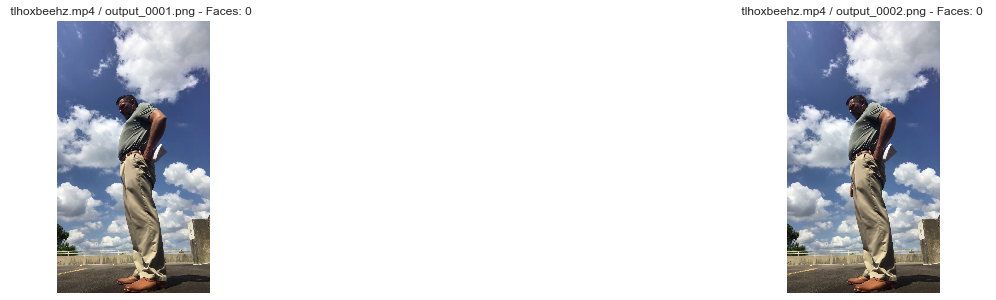

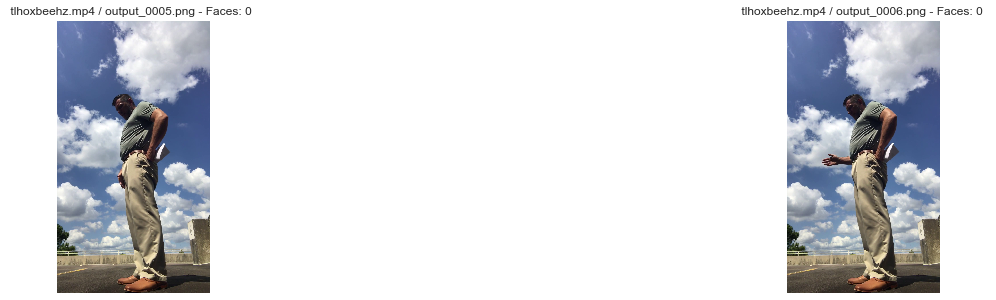

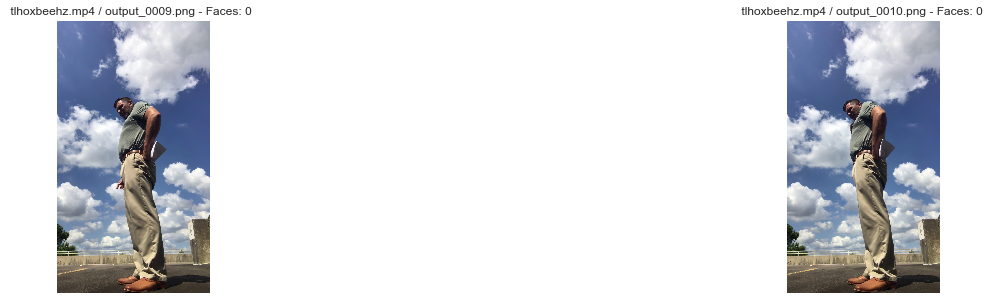

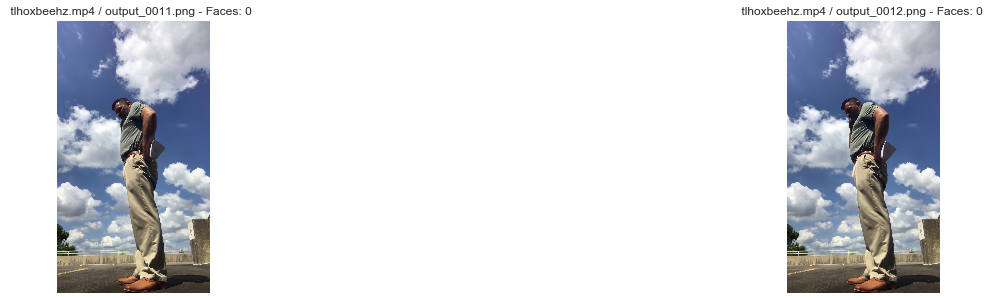

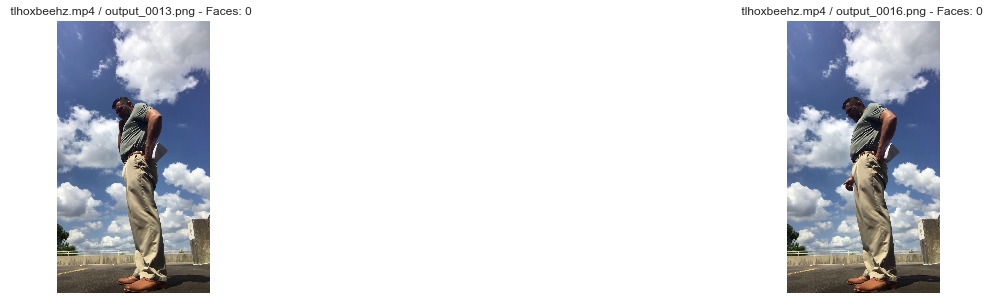

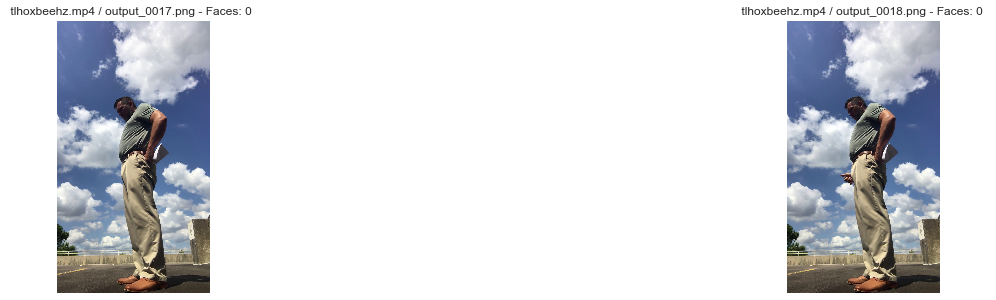

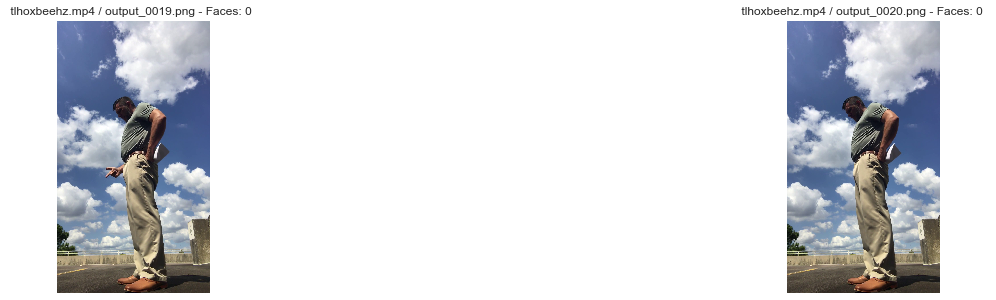

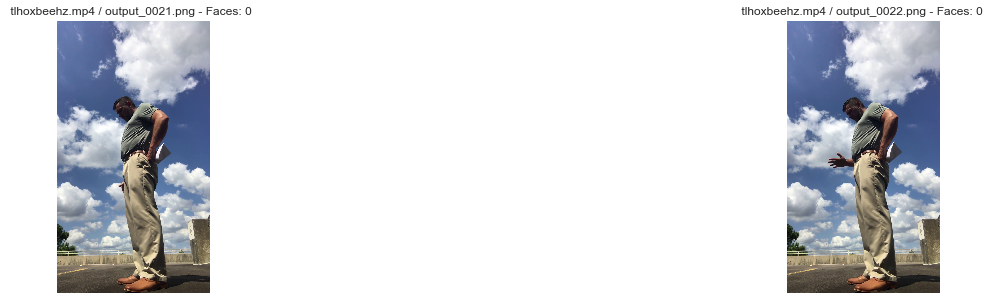

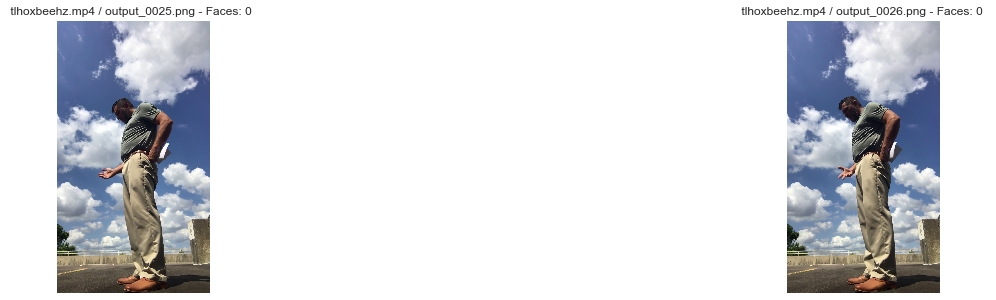

time: 11 s


In [23]:
# MTCNN is not perfect. It detects face inside face and in trees.
plot_faces_boxes(all_faces_pd[all_faces_pd["faces_retina"] == 0], max_items=24) 

In [24]:
for i in tqdm(range(len(train_pd[train_pd["label"] == "FAKE"]))): #
    all_faces_pd = pd.concat([all_faces_pd,  all_faces_pd[all_faces_pd["filename"] == train_pd[train_pd["label"] == "FAKE"]["original"][train_pd[train_pd["label"] == "FAKE"]["original"].index[i]]].replace(train_pd[train_pd["label"] == "FAKE"]["original"][train_pd[train_pd["label"] == "FAKE"]["original"].index[i]],train_pd[train_pd["label"] == "FAKE"]["filename"][train_pd[train_pd["label"] == "FAKE"]["original"].index[i]])], axis=0)
    

100%|██████████████████████████████████████| 1975/1975 [00:32<00:00, 60.84it/s]

time: 32.5 s


In [25]:
#clean_faces_pd = pd.merge(all_faces_pd, train_pd, on="filename", how="left")
clean_faces_pd = pd.merge(all_faces_pd, train_pd, on="filename", how="left")
clean_faces_pd.shape

(43168, 13)

time: 17 ms


In [26]:
# Find out face width/height
def faces_max_item(boxes, idx1, idx2):
    ret = 0
    if len(boxes) > 0:
        ret = max(boxes, key=lambda item: item[idx1][idx2])[idx1][idx2]
    return ret

def faces_max_confidence(boxes):
    ret = 0
    if len(boxes) > 0:
        ret = max(boxes, key=lambda item: item[1])[1]
    return ret

def faces_min_confidence(boxes):
    ret = 0
    if len(boxes) > 0:
        ret = min(boxes, key=lambda item: item[1])[1]
    return ret


# To filter faces with a confidence lower than threshold
def faces_threshold(boxes, conf_thresh = 0.96):
    ret = [] 
    if len(boxes) > 0:
        for i in range(len(boxes)):
            if boxes[i][1] > conf_thresh:
                ret.append(boxes[i])
    
    return ret

def number_of_faces(boxes):
    ret = len(boxes)
    
    return ret

def maximum_number_of_faces(boxes, max_num = 2):
    # Faces are sorted from higher to lower confidence
    # since there are maximum two faces  per video we want to remove the third or 4th value
    
    ret = [] 
    if len(boxes) > max_num:
        for i in range(max_num):    
            ret.append(boxes[i])
    else:
        for i in range(len(boxes)):    
            ret.append(boxes[i])
    
    return ret
    

def fixed_cropping(boxes, w_def = 350, h_def = 450):
    ret = []
    for i in range(len(boxes)):
        original_box = list(boxes[i][0])
        w_box = original_box[2] - original_box[0]
        h_box = original_box[3] - original_box[1]
        c1 = w_box/2 + original_box[0]
        c2= h_box/2 + original_box[1]
        
        large_box = []
        large_box.append(int(c1- w_def/2  ))
        large_box.append(int( c2 - h_def/2 ))
        large_box.append(int( w_def/2+ c1))
        large_box.append(int(h_def/2 + c2))
        
        large_box_tuple = tuple(large_box)
        o = [large_box_tuple, boxes[i][1]]
        n = tuple(o)
        ret.append(n)
             
    return ret

def no_negative_values_in_boxes(boxes, video_height, video_width):
    
    ret = []
    for i in range(len(boxes)):
        final_box = []
        original_box = list(boxes[i][0])
        
        if original_box[0] < 0:
            final_box.append(0)
        else:
            final_box.append(original_box[0])
            
            
        if original_box[1] < 0:
            final_box.append(0)
        else:
            final_box.append(original_box[1])
            
        if original_box[2] < 0:
            final_box.append(video_width)
        else:
            final_box.append(original_box[2])
            
        if original_box[3] < 0:
            final_box.append(video_height)
        else:
            final_box.append(original_box[3])
            
            
        
        final_box_tuple = tuple(final_box)
        o = [final_box_tuple, boxes[i][1]]
        n = tuple(o)
        ret.append(n)
        
    return ret
    

clean_faces_pd["thresh_boxes_retina"] = clean_faces_pd["boxes_retina"].apply(lambda x: faces_threshold(x))
clean_faces_pd["thresh_boxes_retina"] = clean_faces_pd["thresh_boxes_retina"].apply(lambda x: maximum_number_of_faces(x))
clean_faces_pd["thresh_boxes_retina"] = clean_faces_pd["thresh_boxes_retina"].apply(lambda x: no_negative_values_in_boxes(x, clean_faces_pd["video_height"], clean_faces_pd["video_width"]))
clean_faces_pd["faces_max_width"] = clean_faces_pd["thresh_boxes_retina"].apply(lambda x: faces_max_item(x, 0, 2) - faces_max_item(x, 0, 0)) 
clean_faces_pd["faces_max_height"] = clean_faces_pd["thresh_boxes_retina"].apply(lambda x: faces_max_item(x, 0, 3) -faces_max_item(x, 0, 1))
clean_faces_pd["faces_max_conf"] = clean_faces_pd["thresh_boxes_retina"].apply(lambda x: faces_max_confidence(x))
clean_faces_pd["faces_min_conf"] = clean_faces_pd["thresh_boxes_retina"].apply(lambda x: faces_min_confidence(x))
clean_faces_pd["faces_retina"] = clean_faces_pd["thresh_boxes_retina"].apply(lambda x: number_of_faces(x))
clean_faces_pd["fixed_cropping"] = clean_faces_pd["thresh_boxes_retina"].apply(lambda x: fixed_cropping(x))

time: 1.39 s


In [27]:
clean_faces_pd.head()

filename            image  \
0  pgutuxhmdu.mp4  output_0001.png   
1  pgutuxhmdu.mp4  output_0002.png   
2  pgutuxhmdu.mp4  output_0003.png   
3  pgutuxhmdu.mp4  output_0004.png   
4  pgutuxhmdu.mp4  output_0005.png   

                                    boxes_retina  faces_retina label  split  \
0  [((922, 132, 1009, 249), 0.9991245865821838)]  1             REAL  train   
1  [((922, 132, 1009, 249), 0.9991303086280823)]  1             REAL  train   
2  [((923, 133, 1010, 249), 0.9990014433860779)]  1             REAL  train   
3  [((925, 135, 1011, 249), 0.99892657995224)]    1             REAL  train   
4  [((926, 135, 1012, 248), 0.9990665316581726)]  1             REAL  train   

  original  video_height  video_width  video_nb_frames  video_bit_rate  \
0  NaN      1080          1920         300.0            2514587.0        
1  NaN      1080          1920         300.0            2514587.0        
2  NaN      1080          1920         300.0            2514587.0        
3  NaN      1080          1920         300.0            2514587.0        
4  NaN      1080          1920         300.0            2514587.0        

   audio_nb_frames  count                            thresh_boxes_retina  \
0  470.0           NaN     [((922, 132, 1009, 249), 0.9991245865821838)]   
1  470.0           NaN     [((922, 132, 1009, 249), 0.9991303086280823)]   
2  470.0           NaN     [((923, 133, 1010, 249), 0.9990014433860779)]   
3  470.0           NaN     [((925, 135, 1011, 249), 0.99892657995224)]     
4  470.0           NaN     [((926, 135, 1012, 248), 0.9990665316581726)]   

   faces_max_width  faces_max_height  faces_max_conf  faces_min_conf  \
0  87               117               0.999125        0.999125         
1  87               117               0.999130        0.999130         
2  87               116               0.999001        0.999001         
3  86               114               0.998927        0.998927         
4  86               113               0.999067        0.999067         

                                  fixed_cropping  
0  [((790, -34, 1140, 415), 0.9991245865821838)]  
1  [((790, -34, 1140, 415), 0.9991303086280823)]  
2  [((791, -34, 1141, 416), 0.9990014433860779)]  
3  [((793, -33, 1143, 417), 0.99892657995224)]    
4  [((794, -33, 1144, 416), 0.9990665316581726)]

time: 34 ms


In [28]:
# How many faces did we detect?
clean_faces_pd.groupby(["faces_retina"]).count()

filename  image  boxes_retina  label  split  original  \
faces_retina                                                          
0             5393      5393   5393          5393   5393   5182       
1             33839     33839  33839         33839  33839  31202      
2             3936      3936   3936          3936   3936   3776       

              video_height  video_width  video_nb_frames  video_bit_rate  \
faces_retina                                                               
0             5393          5393         5393             5393             
1             33839         33839        33839            33839            
2             3936          3936         3936             3936             

              audio_nb_frames  count  thresh_boxes_retina  faces_max_width  \
faces_retina                                                                 
0             5393             5182   5393                 5393              
1             33839            31202  33839                33839             
2             3936             3776   3936                 3936              

              faces_max_height  faces_max_conf  faces_min_conf  fixed_cropping  
faces_retina                                                                    
0             5393              5393            5393            5393            
1             33839             33839           33839           33839           
2             3936              3936            3936            3936

time: 61 ms


In [29]:
clean_faces_pd[clean_faces_pd["faces_retina"] == 0]

filename            image boxes_retina  faces_retina label  \
2208   tlhoxbeehz.mp4  output_0001.png  []           0             REAL   
2209   tlhoxbeehz.mp4  output_0002.png  []           0             REAL   
2210   tlhoxbeehz.mp4  output_0003.png  []           0             REAL   
2211   tlhoxbeehz.mp4  output_0004.png  []           0             REAL   
2212   tlhoxbeehz.mp4  output_0005.png  []           0             REAL   
...               ...              ...  ..          ..              ...   
43131  yzwdfgqiyp.mp4  output_0028.png  []           0             FAKE   
43132  yzwdfgqiyp.mp4  output_0029.png  []           0             FAKE   
43133  yzwdfgqiyp.mp4  output_0030.png  []           0             FAKE   
43134  yzwdfgqiyp.mp4  output_0031.png  []           0             FAKE   
43135  yzwdfgqiyp.mp4  output_0032.png  []           0             FAKE   

       split        original  video_height  video_width  video_nb_frames  \
2208   train  NaN             1920          1080         300.0             
2209   train  NaN             1920          1080         300.0             
2210   train  NaN             1920          1080         300.0             
2211   train  NaN             1920          1080         300.0             
2212   train  NaN             1920          1080         300.0             
...      ...  ...              ...           ...           ...             
43131  train  nnuwlchsxj.mp4  1920          1080         300.0             
43132  train  nnuwlchsxj.mp4  1920          1080         300.0             
43133  train  nnuwlchsxj.mp4  1920          1080         300.0             
43134  train  nnuwlchsxj.mp4  1920          1080         300.0             
43135  train  nnuwlchsxj.mp4  1920          1080         300.0             

       video_bit_rate  audio_nb_frames  count thresh_boxes_retina  \
2208   2655401.0       432.0           NaN     []                   
2209   2655401.0       432.0           NaN     []                   
2210   2655401.0       432.0           NaN     []                   
2211   2655401.0       432.0           NaN     []                   
2212   2655401.0       432.0           NaN     []                   
...          ...         ...            ..     ..                   
43131  2553078.0       432.0            25.0   []                   
43132  2553078.0       432.0            25.0   []                   
43133  2553078.0       432.0            25.0   []                   
43134  2553078.0       432.0            25.0   []                   
43135  2553078.0       432.0            25.0   []                   

       faces_max_width  faces_max_height  faces_max_conf  faces_min_conf  \
2208   0                0                 0.0             0.0              
2209   0                0                 0.0             0.0              
2210   0                0                 0.0             0.0              
2211   0                0                 0.0             0.0              
2212   0                0                 0.0             0.0              
...   ..               ..                 ...             ...              
43131  0                0                 0.0             0.0              
43132  0                0                 0.0             0.0              
43133  0                0                 0.0             0.0              
43134  0                0                 0.0             0.0              
43135  0                0                 0.0             0.0              

      fixed_cropping  
2208   []             
2209   []             
2210   []             
2211   []             
2212   []             
...    ..             
43131  []             
43132  []             
43133  []             
43134  []             
43135  []             

[5393 rows x 19 columns]

time: 50 ms


In [30]:
clean_faces_pd["faces_retina_avg"] = clean_faces_pd.groupby("filename")["faces_retina"].transform(np.nanmean)
clean_faces_pd["faces_retina_median"] = clean_faces_pd.groupby("filename")["faces_retina"].transform(np.nanmedian)
clean_faces_pd.head()

filename            image  \
0  pgutuxhmdu.mp4  output_0001.png   
1  pgutuxhmdu.mp4  output_0002.png   
2  pgutuxhmdu.mp4  output_0003.png   
3  pgutuxhmdu.mp4  output_0004.png   
4  pgutuxhmdu.mp4  output_0005.png   

                                    boxes_retina  faces_retina label  split  \
0  [((922, 132, 1009, 249), 0.9991245865821838)]  1             REAL  train   
1  [((922, 132, 1009, 249), 0.9991303086280823)]  1             REAL  train   
2  [((923, 133, 1010, 249), 0.9990014433860779)]  1             REAL  train   
3  [((925, 135, 1011, 249), 0.99892657995224)]    1             REAL  train   
4  [((926, 135, 1012, 248), 0.9990665316581726)]  1             REAL  train   

  original  video_height  video_width  video_nb_frames  video_bit_rate  \
0  NaN      1080          1920         300.0            2514587.0        
1  NaN      1080          1920         300.0            2514587.0        
2  NaN      1080          1920         300.0            2514587.0        
3  NaN      1080          1920         300.0            2514587.0        
4  NaN      1080          1920         300.0            2514587.0        

   audio_nb_frames  count                            thresh_boxes_retina  \
0  470.0           NaN     [((922, 132, 1009, 249), 0.9991245865821838)]   
1  470.0           NaN     [((922, 132, 1009, 249), 0.9991303086280823)]   
2  470.0           NaN     [((923, 133, 1010, 249), 0.9990014433860779)]   
3  470.0           NaN     [((925, 135, 1011, 249), 0.99892657995224)]     
4  470.0           NaN     [((926, 135, 1012, 248), 0.9990665316581726)]   

   faces_max_width  faces_max_height  faces_max_conf  faces_min_conf  \
0  87               117               0.999125        0.999125         
1  87               117               0.999130        0.999130         
2  87               116               0.999001        0.999001         
3  86               114               0.998927        0.998927         
4  86               113               0.999067        0.999067         

                                  fixed_cropping  faces_retina_avg  \
0  [((790, -34, 1140, 415), 0.9991245865821838)]  1.0                
1  [((790, -34, 1140, 415), 0.9991303086280823)]  1.0                
2  [((791, -34, 1141, 416), 0.9990014433860779)]  1.0                
3  [((793, -33, 1143, 417), 0.99892657995224)]    1.0                
4  [((794, -33, 1144, 416), 0.9990665316581726)]  1.0                

   faces_retina_median  
0  1                    
1  1                    
2  1                    
3  1                    
4  1

time: 65 ms


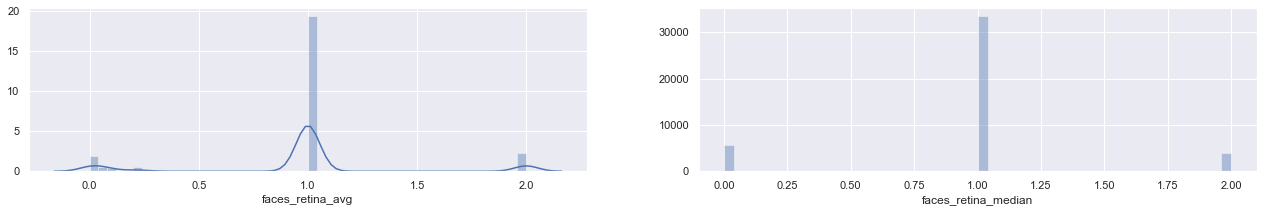

time: 942 ms


In [31]:
fig, ax = plt.subplots(1, 2, figsize=(22, 3))
d = sns.distplot(clean_faces_pd["faces_retina_avg"], kde=True, ax=ax[0])
d = sns.distplot(clean_faces_pd["faces_retina_median"], kde=False, ax=ax[1])

Faces stats:
       faces_max_width  faces_max_height  faces_min_conf  faces_max_conf
count  43168.000000     43168.000000      43168.000000    43168.000000  
mean   114.588908       167.016725        0.873753        0.874365      
std    68.426896        104.006286        0.330159        0.330381      
min    0.000000         0.000000          0.000000        0.000000      
1%     0.000000         0.000000          0.000000        0.000000      
5%     0.000000         0.000000          0.000000        0.000000      
10%    0.000000         0.000000          0.000000        0.000000      
25%    72.000000        104.000000        0.998489        0.998879      
50%    96.000000        138.000000        0.999421        0.999422      
75%    176.000000       252.000000        0.999639        0.999640      
90%    200.000000       283.000000        0.999792        0.999792      
95%    229.000000       372.000000        0.999904        0.999904      
99%    249.000000       387.000000    

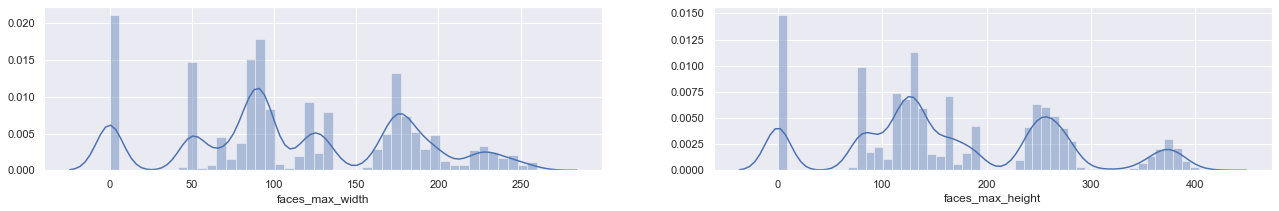

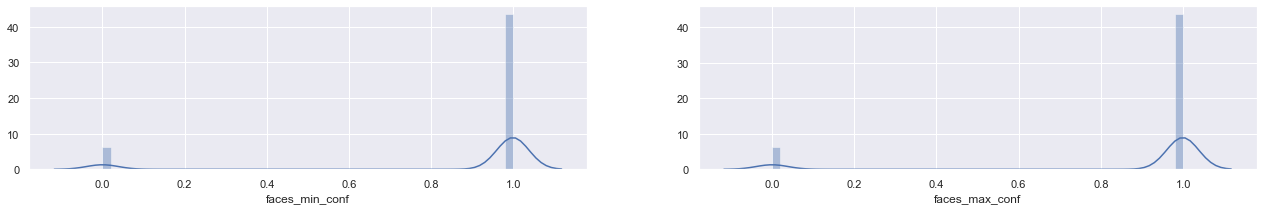

time: 3.16 s


In [32]:
# If we train a CNN, we will have to define a width/height. 256x256 or 320x320 looks good.
print("Faces stats:")
print(clean_faces_pd[["faces_max_width", "faces_max_height", "faces_min_conf", "faces_max_conf"]].describe(percentiles=[0.01,0.05, 0.1,0.25,0.5,0.75,0.9,0.95,0.99]))
fig, ax = plt.subplots(1, 2, figsize=(22, 3))
d = sns.distplot(clean_faces_pd["faces_max_width"], kde=True, ax=ax[0])
d = sns.distplot(clean_faces_pd["faces_max_height"], kde=True, ax=ax[1])
plt.show()
fig, ax = plt.subplots(1, 2, figsize=(22, 3))
d = sns.distplot(clean_faces_pd["faces_min_conf"], kde=True, ax=ax[0])
d = sns.distplot(clean_faces_pd["faces_max_conf"], kde=True, ax=ax[1])
fig, ax = plt.subplots(figsize=(22, 3))
d = clean_faces_pd.plot(kind="scatter", x="faces_max_width", y="faces_max_conf", c="red", ax=ax, label="faces_max_width", alpha=0.5)
d = clean_faces_pd.plot(kind="scatter", x="faces_max_height", y="faces_max_conf", c="blue", ax=d,  label="faces_max_height", alpha=0.5)
d = plt.legend(loc="upper right")

In [33]:
# Plot faces extracted images
def plot_faces_boxes(df, max_cols = 2, max_rows = 6, fsize=(24, 5), max_items=12):    
    idx = 0    
    for item_idx, item in df.iterrows():
        img = cv2.cvtColor(cv2.imread(IMAGES_FOLDER_TRAIN + "/" + item["filename"][:-4] +"/" + item["image"], cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)    
        face_img = img #.copy()
        # grid subplots
        row = idx // max_cols
        col = idx % max_cols
        if col == 0: fig = plt.figure(figsize=fsize)
        ax = fig.add_subplot(1, max_cols, col + 1)
        ax.axis("off")
        # display image with boxes
        cols = [c for c in df.columns if "thresh_boxes_retina" in c]
        for i, c in enumerate(cols, 0):
            face_locations = item[c]
            face_confidence = item[c]            
            if len(face_locations) > 0:
                for face_location in face_locations:        
                    ((x,y,w,h), confidence) = face_location
                    # face_img = face_img[y:y+h, x:x+w]
                    cv2.rectangle(face_img, (x, y), (w, h), (255,i*255,0), 8)
                    cv2.putText(face_img, '%.1f' % (confidence*100.0), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (255,i*255,0), 9, cv2.LINE_AA)
                ax.imshow(face_img)
            else:
                ax.imshow(img)
            ax.set_title("%s %s / %s - Faces: %d %s %s" % (item["label"] if "label" in df.columns else "", 
                                                           item["filename"], item["image"],
                                                           item["faces_retina"] if "faces_retina" in df.columns else len(face_locations),
                                                           item["faces_retina_median"] if "faces_retina_median" in df.columns else "",
                                                           item["faces"] if "faces" in df.columns else ""))
        if (col == max_cols -1): plt.show()
        idx = idx + 1
        if (max_items > 0 and idx >=max_items): break

time: 6 ms


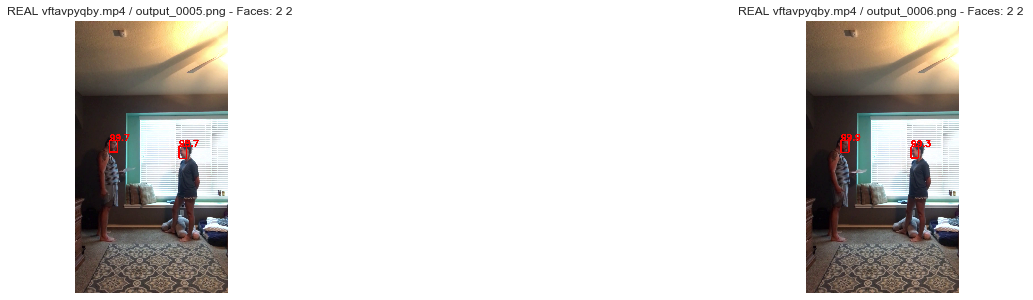

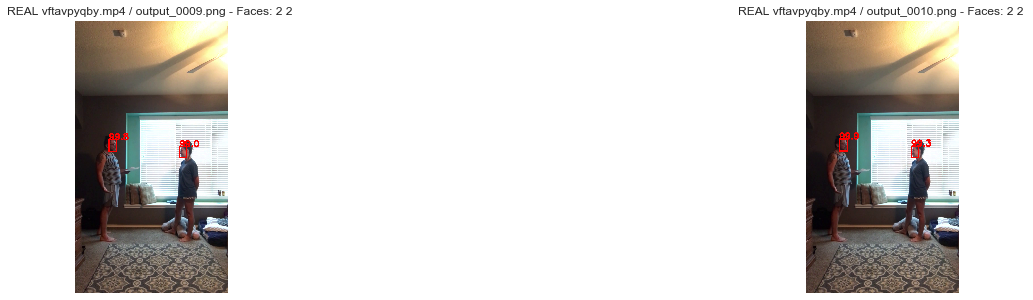

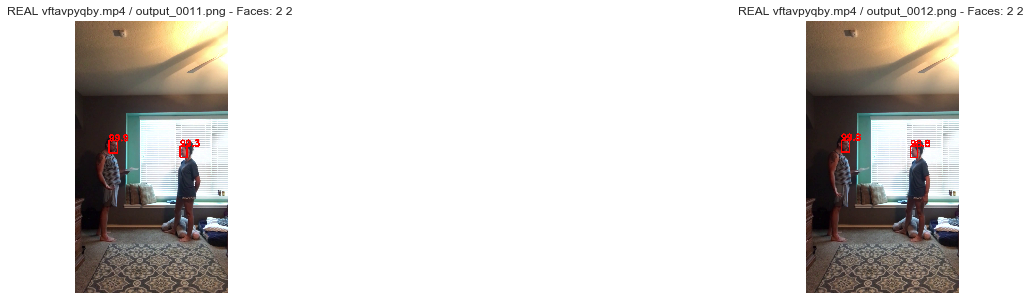

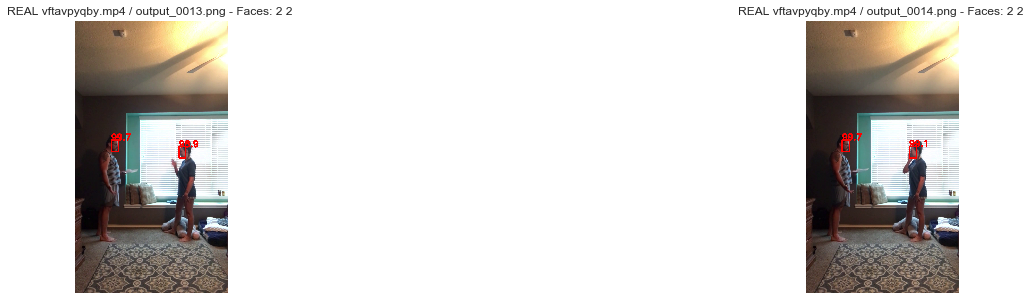

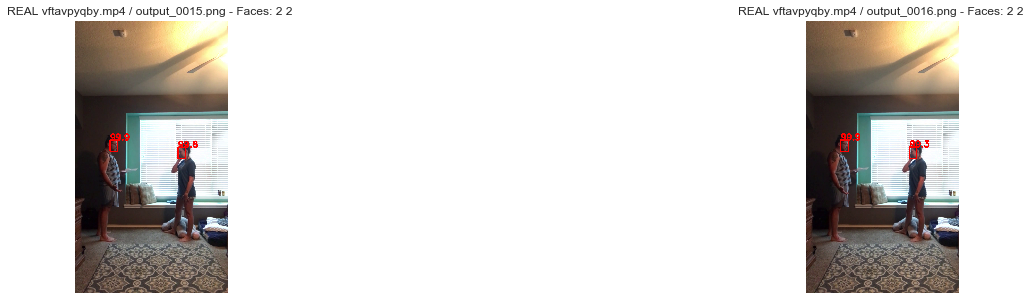

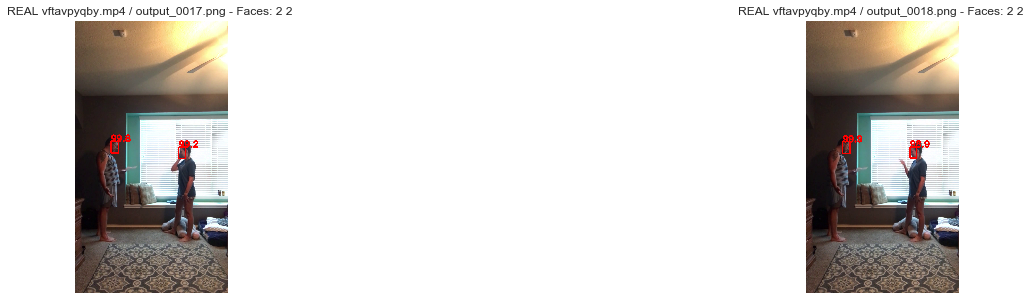

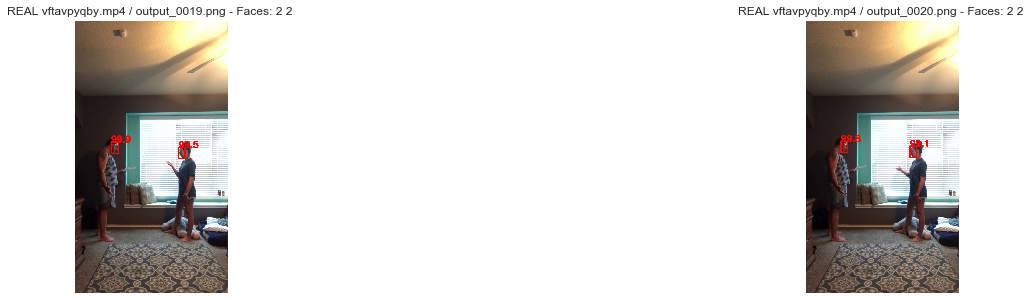

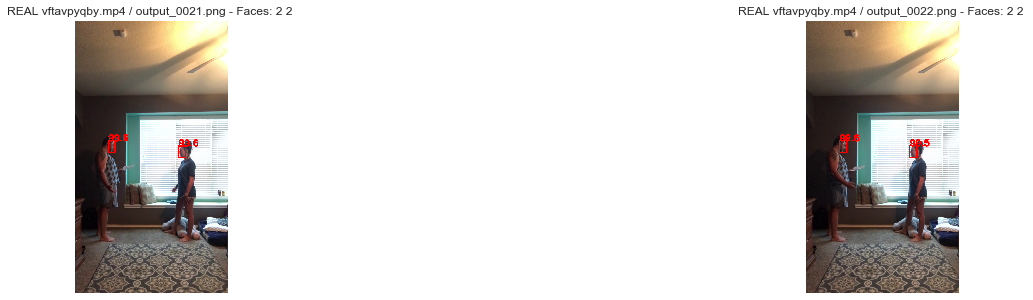

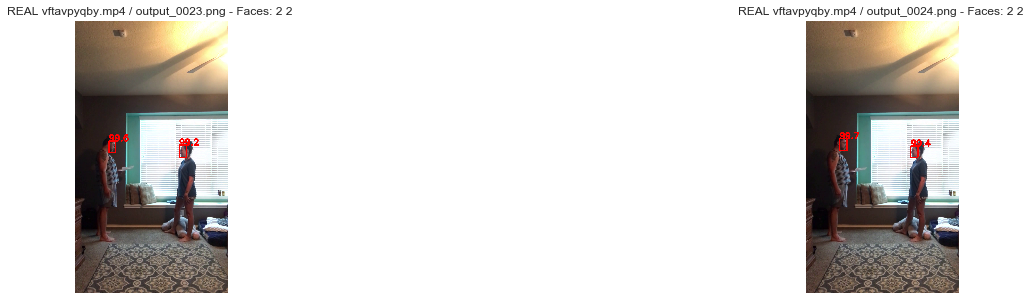

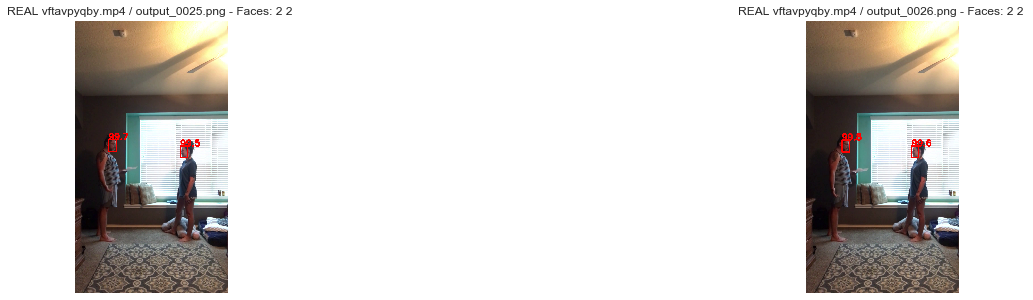

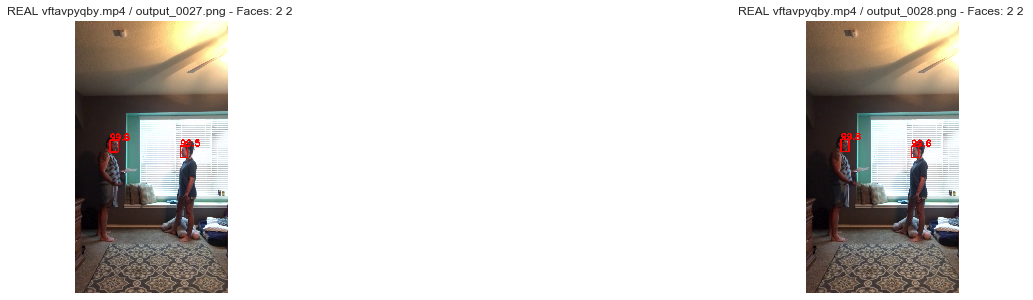

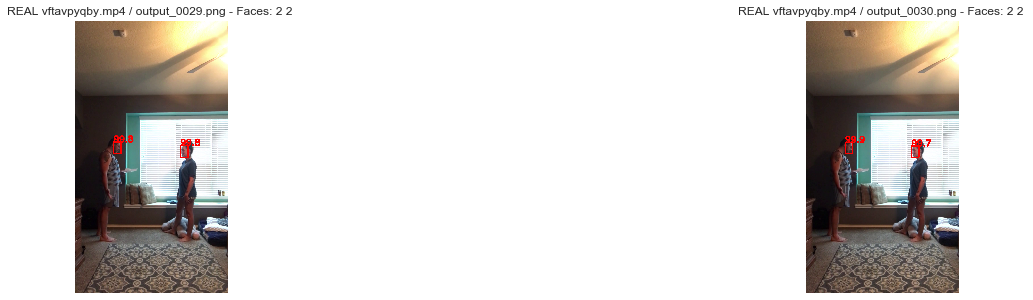

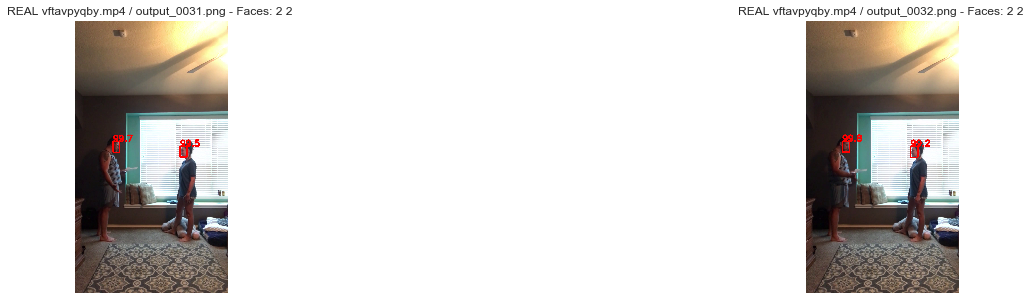

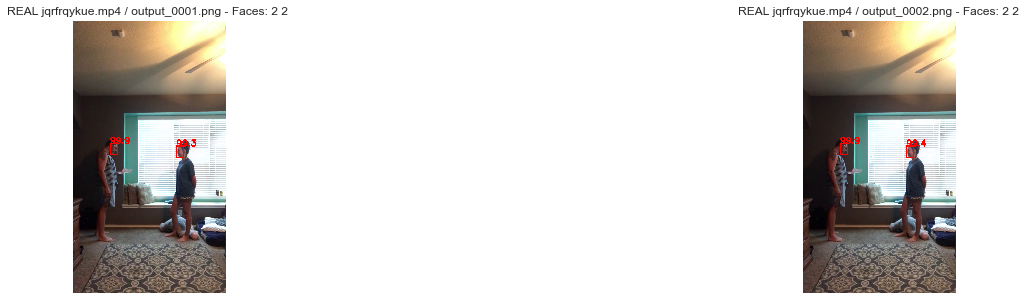

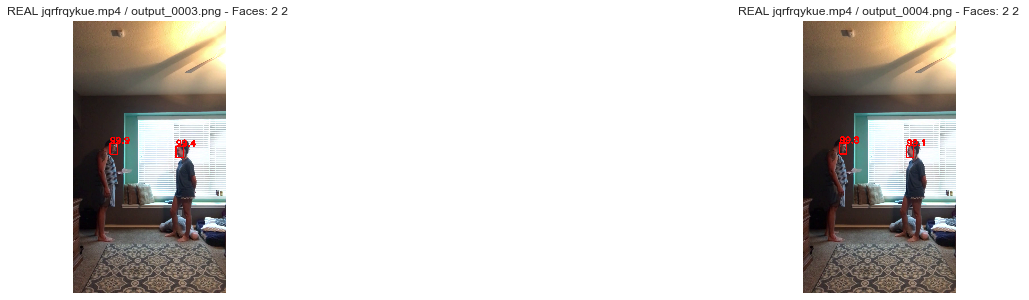

time: 16.3 s


In [34]:
# MTCNN is not perfect. It detects faces inside faces and in trees.
plot_faces_boxes(clean_faces_pd[clean_faces_pd["faces_retina"] == 2], max_items=36)

In [35]:
clean_faces = clean_faces_pd[clean_faces_pd["faces_retina"] != 0]

time: 9.01 ms


Faces stats:
       faces_max_width  faces_max_height  faces_min_conf  faces_max_conf
count  37775.000000     37775.000000      37775.000000    37775.000000  
mean   130.948352       190.861099        0.998495        0.999195      
std    56.642965        88.377670         0.003094        0.001470      
min    44.000000        75.000000         0.971537        0.971537      
1%     49.000000        77.000000         0.984260        0.994819      
5%     50.000000        80.000000         0.991724        0.997713      
10%    53.000000        85.000000         0.995128        0.998467      
25%    87.000000        120.000000        0.999228        0.999231      
50%    121.000000       163.000000        0.999475        0.999476      
75%    177.000000       257.000000        0.999660        0.999661      
90%    212.000000       346.000000        0.999841        0.999841      
95%    232.000000       373.000000        0.999910        0.999910      
99%    249.000000       388.000000    

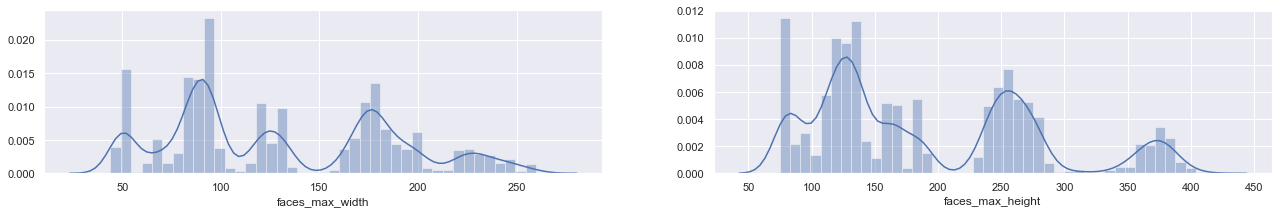

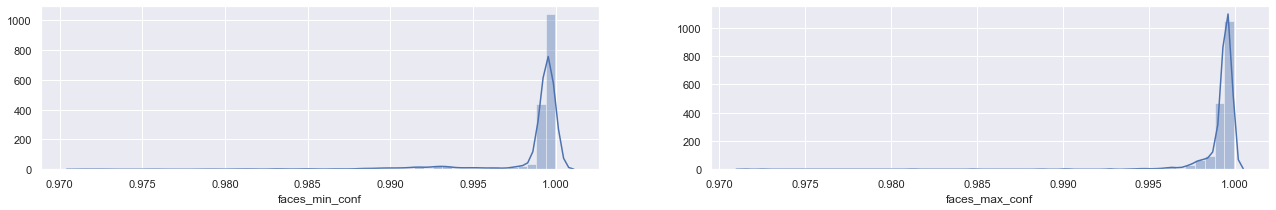

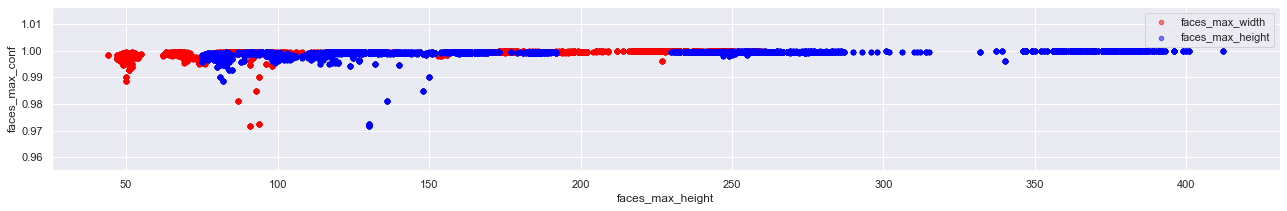

time: 3.28 s


In [36]:
# If we train a CNN, we will have to define a width/height. 256x256 or 320x320 looks good.
print("Faces stats:")
print(clean_faces[["faces_max_width", "faces_max_height", "faces_min_conf", "faces_max_conf"]].describe(percentiles=[0.01,0.05, 0.1,0.25,0.5,0.75,0.9,0.95,0.99]))
fig, ax = plt.subplots(1, 2, figsize=(22, 3))
d = sns.distplot(clean_faces["faces_max_width"], kde=True, ax=ax[0])
d = sns.distplot(clean_faces["faces_max_height"], kde=True, ax=ax[1])
plt.show()
fig, ax = plt.subplots(1, 2, figsize=(22, 3))
d = sns.distplot(clean_faces["faces_min_conf"], kde=True, ax=ax[0])
d = sns.distplot(clean_faces["faces_max_conf"], kde=True, ax=ax[1])
fig, ax = plt.subplots(figsize=(22, 3))
d = clean_faces.plot(kind="scatter", x="faces_max_width", y="faces_max_conf", c="red", ax=ax, label="faces_max_width", alpha=0.5)
d = clean_faces.plot(kind="scatter", x="faces_max_height", y="faces_max_conf", c="blue", ax=d,  label="faces_max_height", alpha=0.5)
d = plt.legend(loc="upper right")

In [37]:
def crop_faces(input_path , output_path, boxes):
    
    # in
    img = cv2.imread(input_path)
    # Draw rectangle around the faces and locally save faces as new images 
    for i in range(len(boxes)):
        box = list(boxes[i][0])
        roi = img[box[1]:box[3], box[0]:box[2]] 
        cv2.imwrite(output_path +'/'+input_path[-15:] + '_faces'+ str(i) +'.png', roi) 


        

time: 1 ms


In [38]:
cropped_images_folder_path = CROPPED_IMAGES_FOLDER
images_folder_path = IMAGES_FOLDER_TRAIN
if EXTRACT_CONTENT == True:
    # Crop Faces
    for idx, row in tqdm(clean_faces.iterrows(), total=clean_faces.shape[0]):
        try:
            #subfolder = images_folder_path + "/" + row["filename"][:-4]
            image_path = images_folder_path + "/" + row["filename"][:-4]  + "/" + row["image"]
            cropped_images_path = cropped_images_folder_path  + "/" + row["filename"][:-4]
            #boxes = row["fixed_cropping"]
            boxes = row["thresh_boxes_retina"]
            
            # Extract images
            if not os.path.exists(cropped_images_path): os.makedirs(cropped_images_path)
                
            ### ToDo --> function which crops according to "fixed_cropping" column 
            #for file in images_path:
            ### ToDo --> function which crops according to "fixed_cropping" column 
            crop_faces(image_path, cropped_images_path, boxes)
        except:
            print("Cannot crop frames for:" + row["filename"][:-4]  + "/" + row["image"])
 

100%|████████████████████████████████████| 37775/37775 [58:32<00:00, 10.75it/s]

time: 58min 32s


In [39]:
# riFARE CON 9
# Rifare con 36
# 35 aveva dei video nel dataframe che non erano nella cartella, 
# ma a quanto pare dal blog e' proprio cosi, c'e stato un leakage


clean_faces.to_pickle(HOME + "faces_train_"+str(num)+".pkl")

time: 118 ms


In [40]:
clean_faces_pd.shape

(43168, 21)

time: 2 ms


In [41]:
(clean_faces_pd.shape[0]- clean_faces.shape[0])/clean_faces_pd.shape[0]

0.12493050407709415

time: 18 ms
